<a href="https://colab.research.google.com/github/marcvonrohr/DeepLearning/blob/main/meta_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import json
import random
from google.colab import drive

#################################################################
#  STEP 2.1: PREPARE LOCAL VM
#################################################################

# --- 1. Mount Google Drive ---
print("Connecting Google Drive...")
drive.mount('/content/drive')
print("...Google Drive connected.")

# --- 2. Define Key Paths ---
GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')
DATASETS_ROOT_DIR = os.path.join(PROJECT_DIR, 'datasets')
INAT_ROOT_DIR = os.path.join(DATASETS_ROOT_DIR, 'inaturalist')

# Source: The COMPRESSED archives
ARCHIVES_DIR_ON_DRIVE = os.path.join(INAT_ROOT_DIR, 'archives')

# Target: The LOCAL VM fast disk
LOCAL_DATA_ROOT = '/content/data'
# This is the final path your PyTorch code will use:
FINAL_DATA_PATH = os.path.join(LOCAL_DATA_ROOT, 'inaturalist_unpacked')

# Define source/destination paths
TAR_FILES = {
    "2021_train_mini": {
        "src": os.path.join(ARCHIVES_DIR_ON_DRIVE, '2021_train_mini.tar.gz'),
        "dest_tar": os.path.join(LOCAL_DATA_ROOT, '2021_train_mini.tar.gz'),
        "check_unpacked": os.path.join(FINAL_DATA_PATH, '2021_train_mini')
    },
    "2021_valid": {
        "src": os.path.join(ARCHIVES_DIR_ON_DRIVE, '2021_valid.tar.gz'),
        "dest_tar": os.path.join(LOCAL_DATA_ROOT, '2021_valid.tar.gz'),
        "check_unpacked": os.path.join(FINAL_DATA_PATH, '2021_valid')
    }
}

# --- 3. Create Local Directories on VM ---
os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)
os.makedirs(FINAL_DATA_PATH, exist_ok=True)
print(f"Local data directory created at: {FINAL_DATA_PATH}")

# --- 4. Copy, Unpack, and Clean up for each file ---
for name, paths in TAR_FILES.items():
    print(f"\n--- Processing {name} ---")

    if os.path.exists(paths["check_unpacked"]):
        print(f"'{name}' is already unpacked in local VM. Skipping.")
        continue

    # 4a. Copy .tar.gz from Drive to local VM
    print(f"Copying '{name}.tar.gz' from Drive to local VM...")
    start_time = time.time()
    !cp "{paths['src']}" "{paths['dest_tar']}"
    print(f"...Copy complete. Took {time.time() - start_time:.2f} seconds.")

    # 4b. Unpack the file on the local VM
    print(f"Unpacking '{name}.tar.gz' locally...")
    start_time = time.time()
    !tar -xzf "{paths['dest_tar']}" -C "{FINAL_DATA_PATH}"
    print(f"...Unpacking complete. Took {time.time() - start_time:.2f} seconds.")

    # 4c. Delete the local .tar.gz file to save VM space
    print(f"Deleting local tarball '{paths['dest_tar']}'...")
    !rm "{paths['dest_tar']}"
    print("...Local tarball deleted.")

# --- 5. Verify and Set Path for Training ---
print("\n--- Final Data Setup Verification ---")
print(f"Dataset is ready for training at: {FINAL_DATA_PATH}")
!ls -lh "{FINAL_DATA_PATH}"
print("\nLocal VM Disk Space Usage:")
!df -h

Connecting Google Drive...
Mounted at /content/drive
...Google Drive connected.
Local data directory created at: /content/data/inaturalist_unpacked

--- Processing 2021_train_mini ---
Copying '2021_train_mini.tar.gz' from Drive to local VM...
...Copy complete. Took 922.06 seconds.
Unpacking '2021_train_mini.tar.gz' locally...
...Unpacking complete. Took 425.80 seconds.
Deleting local tarball '/content/data/2021_train_mini.tar.gz'...
...Local tarball deleted.

--- Processing 2021_valid ---
Copying '2021_valid.tar.gz' from Drive to local VM...
...Copy complete. Took 191.23 seconds.
Unpacking '2021_valid.tar.gz' locally...
...Unpacking complete. Took 77.88 seconds.
Deleting local tarball '/content/data/2021_valid.tar.gz'...
...Local tarball deleted.

--- Final Data Setup Verification ---
Dataset is ready for training at: /content/data/inaturalist_unpacked
total 2.5M
drwxrwxr-x 10002 1000 1000 1.3M Oct 13  2020 train_mini
drwxrwxr-x 10002 1000 1000 1.3M Oct 13  2020 val

Local VM Disk Spac

In [2]:
#################################################################
#  STEP 2.2: SCIENTIFIC DATA PARTITIONING
#################################################################
print("\n--- STEP 2.2: Loading/Creating Scientific Class Partition ---")

# --- 6. Define Paths for Partition File ---
# We create a 'project_meta' folder on GDrive to store helper files
META_DIR_ON_DRIVE = os.path.join(PROJECT_DIR, 'project_meta')
os.makedirs(META_DIR_ON_DRIVE, exist_ok=True)

PARTITION_FILE_PATH = os.path.join(META_DIR_ON_DRIVE, 'inat_class_split.json')
print(f"Looking for partition file at: {PARTITION_FILE_PATH}")


--- STEP 2.2: Loading/Creating Scientific Class Partition ---
Looking for partition file at: /content/drive/MyDrive/Deep Learning/project_meta/inat_class_split.json


In [3]:
# --- 7. Logic to Find Classes and Create Partition ---

# 7a. Identify the Dataset Root
# The unpacking might have created a subfolder (e.g., '2021_train_mini' or 'train_mini')
# or files might be directly in FINAL_DATA_PATH. We check common patterns.
possible_roots = [
    os.path.join(FINAL_DATA_PATH, '2021_train_mini'),
    os.path.join(FINAL_DATA_PATH, 'train_mini'),
    FINAL_DATA_PATH
]

DATASET_ROOT = None
for path in possible_roots:
    if os.path.exists(path):
        # Check if this path actually contains subdirectories
        if len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]) > 0:
            DATASET_ROOT = path
            break

print(f"Dataset root identified as: {DATASET_ROOT}")

# 7b. Load or Create the Partition
partition_data = {}
RANDOM_SEED = 42

if os.path.exists(PARTITION_FILE_PATH):
    print("Found existing partition file. Loading...")
    with open(PARTITION_FILE_PATH, 'r') as f:
        partition_data = json.load(f)
else:
    print("No partition file found. Scanning directories to create new partition...")
    print("This ensures independence from missing metadata files.")

    # --- Scan for Class Folders ---
    class_folders_rel = []

    # Walk through the directory tree
    # A "class" is any folder that contains image files (.jpg, .jpeg, .png)
    print("Scanning folders (this may take 1-2 minutes)...")
    for root, dirs, files in os.walk(DATASET_ROOT):
        # Check for images in this specific folder
        images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) > 0:
            # Get path relative to the dataset root (e.g., "Aves/Turdus_migratorius")
            rel_path = os.path.relpath(root, DATASET_ROOT)
            class_folders_rel.append(rel_path)

    # --- CRITICAL: Sort for Reproducibility ---
    # Sorting ensures that Index 0 is ALWAYS the same class on every machine/run
    class_folders_rel.sort()

    num_classes = len(class_folders_rel)
    print(f"Found {num_classes} classes containing images.")

    if num_classes < 9900:
        print("WARNING: Found significantly fewer than 10,000 classes. Check extraction.")

    # --- Assign IDs and Shuffle ---
    all_class_ids = list(range(num_classes))

    print(f"Shuffling {num_classes} class IDs with random seed {RANDOM_SEED}...")
    random.seed(RANDOM_SEED)
    random.shuffle(all_class_ids)

    # --- Split into Sets ---
    # 6000 Base (Train/Meta-Train), 2000 Val (Hyperparams), 2000 Novel (Test)
    c_base_ids = all_class_ids[:6000]
    c_val_ids = all_class_ids[6000:8000]
    c_novel_ids = all_class_ids[8000:]

    # --- Construct Data Structure ---
    # We save both the sets AND the mapping from ID -> Folder Path
    partition_data = {
        "sets": {
            'c_base': sorted(c_base_ids),
            'c_val': sorted(c_val_ids),
            'c_novel': sorted(c_novel_ids)
        },
        "id_to_path": {
            str(i): folder_path for i, folder_path in enumerate(class_folders_rel)
        }
    }

    # --- Save to Drive ---
    print(f"Saving new partition and mapping to: {PARTITION_FILE_PATH}")
    with open(PARTITION_FILE_PATH, 'w') as f:
        json.dump(partition_data, f, indent=4)

Dataset root identified as: /content/data/inaturalist_unpacked/train_mini
Found existing partition file. Loading...


In [4]:
# --- 8. Verification ---
print("\n--- Partitioning Complete ---")
sets = partition_data['sets']
print(f"Total C_base classes:  {len(sets['c_base'])}")
print(f"Total C_val classes:   {len(sets['c_val'])}")
print(f"Total C_novel classes: {len(sets['c_novel'])}")

# Check for overlaps (should be 0)
base_set = set(sets['c_base'])
val_set = set(sets['c_val'])
novel_set = set(sets['c_novel'])

overlap_bv = base_set & val_set
overlap_bn = base_set & novel_set
overlap_vn = val_set & novel_set

print(f"Overlap (Base-Val):    {len(overlap_bv)}")
print(f"Overlap (Base-Novel):  {len(overlap_bn)}")
print(f"Overlap (Val-Novel):   {len(overlap_vn)}")

if len(overlap_bv) + len(overlap_bn) + len(overlap_vn) == 0:
    print("\nSUCCESS: Classes are cleanly partitioned.")
else:
    print("\nCRITICAL ERROR: Overlaps detected in class sets!")


--- Partitioning Complete ---
Total C_base classes:  6000
Total C_val classes:   2000
Total C_novel classes: 2000
Overlap (Base-Val):    0
Overlap (Base-Novel):  0
Overlap (Val-Novel):   0

SUCCESS: Classes are cleanly partitioned.


In [5]:
#################################################################
#  STEP 2.3: MODULAR DATA LOADERS (NO LEARN2LEARN DEPENDENCY)
#################################################################
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

print("\n--- STEP 2.3: Initialize Custom Data Loaders (Native PyTorch) ---")

# --- SAFETY CHECK ---
# Ensure variables from Step 2.2 exist
required_vars = ['DATASET_ROOT', 'PARTITION_FILE_PATH']
if not all(v in globals() for v in required_vars):
    raise NameError(f"Missing variables from Step 2.2. Please run the previous cell.")

print(f"Using Dataset Root: {DATASET_ROOT}")
print(f"Using Partition File: {PARTITION_FILE_PATH}")

# --- CONSTANTS ---
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]


--- STEP 2.3: Initialize Custom Data Loaders (Native PyTorch) ---
Using Dataset Root: /content/data/inaturalist_unpacked/train_mini
Using Partition File: /content/drive/MyDrive/Deep Learning/project_meta/inat_class_split.json


In [6]:
# ==============================================================================
#  CORE COMPONENT: The Custom Dataset Class
# ==============================================================================
class MetaINatDataset(Dataset):
    """
    A custom PyTorch Dataset that enforces the scientific partition.
    """
    def __init__(self, root_dir, partition_file, split='c_base', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        with open(partition_file, 'r') as f:
            data = json.load(f)

        if split not in data['sets']:
            raise ValueError(f"Invalid split '{split}'. Available: {list(data['sets'].keys())}")

        self.allowed_ids = data['sets'][split]
        self.id_to_path = data['id_to_path']

        # Map original ID -> 0..N-1
        self.label_map = {orig: new for new, orig in enumerate(self.allowed_ids)}

        self.samples = []
        for original_id in self.allowed_ids:
            rel_path = self.id_to_path[str(original_id)]
            abs_path = os.path.join(self.root_dir, rel_path)
            if os.path.exists(abs_path):
                for img in os.listdir(abs_path):
                    if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.samples.append({
                            'path': os.path.join(abs_path, img),
                            'label': self.label_map[original_id]
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# ==============================================================================
#  HELPER: Episodic Batch Generator (Replaces learn2learn)
# ==============================================================================
class EpisodicTaskGenerator:
    """
    Native PyTorch implementation of an N-Way K-Shot task sampler.
    Replaces learn2learn functionality without installation issues.
    """
    def __init__(self, dataset, ways, shots, query_shots):
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.query_shots = query_shots

        # Group all image indices by their label for fast sampling
        self.indices_by_label = {}
        for idx, sample in enumerate(dataset.samples):
            lbl = sample['label']
            if lbl not in self.indices_by_label:
                self.indices_by_label[lbl] = []
            self.indices_by_label[lbl].append(idx)

        self.classes = list(self.indices_by_label.keys())

    def __iter__(self):
        return self

    def __next__(self):
        # 1. Sample N random classes (Ways)
        selected_classes = random.sample(self.classes, self.ways)

        batch_images = []
        batch_labels = []

        # 2. Sample K + Q images from each class
        for local_label, global_label_idx in enumerate(selected_classes):
            indices = self.indices_by_label[global_label_idx]

            # Ensure we have enough images, otherwise sample with replacement
            needed = self.shots + self.query_shots
            if len(indices) >= needed:
                selected_indices = random.sample(indices, needed)
            else:
                selected_indices = random.choices(indices, k=needed)

            # 3. Load images and re-label them to 0..N-1 for the episode
            for idx in selected_indices:
                img, _ = self.dataset[idx] # dataset returns (img, global_label)
                batch_images.append(img)
                # Important: The label for the loss function must be 0..Ways-1
                batch_labels.append(local_label)

        # Stack into a single tensor: [Ways * (Shots+Query), C, H, W]
        data = torch.stack(batch_images)
        labels = torch.tensor(batch_labels)

        return data, labels

    def sample(self):
        # Compatibility method to look like learn2learn
        return self.__next__()

In [8]:
# ==============================================================================
#  LOADER A: Standard Pre-Training Loader
# ==============================================================================
def get_standard_loader(split='c_base', batch_size=64, shuffle=True):
    print(f"\n[Loader A] Initializing Standard Loader for split '{split}'...")

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])

    dataset = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=train_transforms)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

    print(f" -> {len(dataset)} total images.")
    print(f" -> {len(dataset.allowed_ids)} classes.")
    return loader, len(dataset.allowed_ids)

In [9]:
# ==============================================================================
#  LOADER B: Episodic Task Loader (MAML) - NATIVE IMPLEMENTATION
# ==============================================================================
def get_episodic_taskset(split='c_base', ways=5, shots=1, query_shots=1, img_size=84):
    print(f"\n[Loader B] Initializing Episodic Generator for split '{split}'...")

    maml_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])

    dataset = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=maml_transforms)

    # Use our native generator instead of learn2learn
    task_generator = EpisodicTaskGenerator(
        dataset,
        ways=ways,
        shots=shots,
        query_shots=query_shots
    )

    print(f" -> Configured {ways}-Way {shots}-Shot Tasks (Native PyTorch).")
    return task_generator

In [10]:
# ==============================================================================
#  LOADER C: Fixed Few-Shot Loader for FT/LoRA
# ==============================================================================
def get_fixed_few_shot_task(split='c_novel', ways=5, shots=1, query_shots=15, seed=None):
    print(f"\n[Loader C] Creating Fixed Few-Shot Task from '{split}'...")

    if seed:
        random.seed(seed)
        torch.manual_seed(seed)

    eval_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])

    dataset = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=eval_transforms)

    available_labels = list(set(s['label'] for s in dataset.samples))
    selected_classes = random.sample(available_labels, ways)

    class_indices = {c: [] for c in selected_classes}
    for idx, sample in enumerate(dataset.samples):
        if sample['label'] in selected_classes:
            class_indices[sample['label']].append(idx)

    support_indices = []
    query_indices = []

    for c in selected_classes:
        idxs = class_indices[c]
        random.shuffle(idxs)
        support_indices.extend(idxs[:shots])
        query_indices.extend(idxs[shots : shots+query_shots])

    support_loader = DataLoader(Subset(dataset, support_indices), batch_size=16, shuffle=True)
    query_loader = DataLoader(Subset(dataset, query_indices), batch_size=32, shuffle=False)

    print(f" -> Support Set: {len(support_indices)} images, Query Set: {len(query_indices)} images")
    return support_loader, query_loader

In [11]:
# ==============================================================================
#  VERIFICATION
# ==============================================================================
print("\n--- Testing Loaders ---")

# Test A
try:
    l_std, n_cls = get_standard_loader(split='c_base', batch_size=4)
    print("Loader A (Standard) check: OK.")
except Exception as e:
    print(f"Loader A Failed: {e}")

# Test B (Now using Native Generator)
try:
    task_gen = get_episodic_taskset(split='c_base', ways=5, shots=1, query_shots=1)
    batch_data, batch_labels = task_gen.sample()
    # Expected shape: [Way*(Shot+Query), 3, 84, 84] -> [5*(1+1), 3, 84, 84] = [10, 3, 84, 84]
    print(f"Loader B (Episodic) check: OK. Batch shape: {batch_data.shape}")
    if batch_labels.max() >= 5:
        print("WARNING: Labels not properly remapped to 0..N-1")
except Exception as e:
    print(f"Loader B Failed: {e}")

# Test C
try:
    sup_dl, q_dl = get_fixed_few_shot_task(split='c_novel', ways=5, shots=5)
    print("Loader C (Fixed) check: OK.")
except Exception as e:
    print(f"Loader C Failed: {e}")

print("\nStep 2.3 Complete (Dependencies Fixed).")


--- Testing Loaders ---

[Loader A] Initializing Standard Loader for split 'c_base'...
 -> 300000 total images.
 -> 6000 classes.
Loader A (Standard) check: OK.

[Loader B] Initializing Episodic Generator for split 'c_base'...
 -> Configured 5-Way 1-Shot Tasks (Native PyTorch).
Loader B (Episodic) check: OK. Batch shape: torch.Size([10, 3, 84, 84])

[Loader C] Creating Fixed Few-Shot Task from 'c_novel'...
 -> Support Set: 25 images, Query Set: 75 images
Loader C (Fixed) check: OK.

Step 2.3 Complete (Dependencies Fixed).


In [13]:
#################################################################
#  PHASE 4: INTELLIGENT PRE-TRAINING (MAX PERF & MEMORY SAFE)
#################################################################
import os
import time
import shutil
import random
import gc  # <--- WICHTIG für Garbage Collection
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast, GradScaler
from google.colab import drive

print("\n--- PHASE 4: Pipeline 0 - Base Model Pre-Training ---")

# --- 0. DRIVE & PATH SETUP ---
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')
MODELS_DIR = os.path.join(PROJECT_DIR, 'models', 'base_models')
os.makedirs(MODELS_DIR, exist_ok=True)

# --- 1. SEED SETUP ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# --- 2. HARDWARE DETECTION (TUNED FOR A100) ---
def get_optimal_config():
    cpu_count = os.cpu_count()
    optimal_workers = min(cpu_count, 8)
    device_name = "CPU"
    batch_size = 16

    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        device_name = gpu_name
        # --- TUNING ---
        if "A100" in gpu_name:
            batch_size = 512  # <--- Aggressiver für A100 (40GB VRAM erlaubt das locker)
        elif "T4" in gpu_name:
            batch_size = 128
        else:
            batch_size = 64
    else:
        print("WARNING: No GPU detected!")

    return device_name, batch_size, optimal_workers

detected_device, auto_bs, auto_workers = get_optimal_config()

# --- 3. CONFIGURATION ---
CONFIG = {
    'ARCH': 'resnet34',

    # --- CONTROL CENTER ---
    'DRY_RUN': False,            # <--- REAL TRAINING
    'NUM_EPOCHS': 20,
    # ----------------------

    'BATCH_SIZE': auto_bs,
    'NUM_WORKERS': auto_workers,
    'DEVICE_NAME': detected_device,
    'LEARNING_RATE': 1e-3,
    'PATIENCE': 5,
    'SUBSETS': [0.25, 0.50, 1.0],

    'CHECKPOINT_DIR_LOC': '/content/checkpoints',
    'CHECKPOINT_DIR_DRIVE': MODELS_DIR
}

os.makedirs(CONFIG['CHECKPOINT_DIR_LOC'], exist_ok=True)

print(f"\nSystem Configuration:")
print(f" -> Hardware:    {CONFIG['DEVICE_NAME']}")
print(f" -> Batch Size:  {CONFIG['BATCH_SIZE']} (Optimized)")
print(f" -> Workers:     {CONFIG['NUM_WORKERS']}")
print(f" -> Mode:        {'DRY RUN' if CONFIG['DRY_RUN'] else 'REAL TRAINING'}")

# --- 4. MEMORY CLEANUP HELPER (NEW) ---
def cleanup_memory():
    """Forces Garbage Collection and clears GPU Cache."""
    gc.collect()
    torch.cuda.empty_cache()
    # Optional: Print stats to verify
    # print(f"   [Mem] Reserved: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")


# --- 5. MODEL FACTORY ---
def get_base_model(arch_name, num_classes, pretrained=True):
    # Loading logic same as before
    if arch_name == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
        in_features = model.fc.in_features
    elif arch_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_features = model.fc.in_features
    elif arch_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        in_features = model.fc.in_features
    else:
        raise ValueError("Arch not supported")
    model.fc = nn.Linear(in_features, num_classes)
    return model

# --- 6. DATA LOADER HELPER ---
def get_subset_loader(fraction):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])

    full_ds = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split='c_base', transform=train_transforms)

    total_base_classes = len(full_ds.allowed_ids)
    target_num = int(total_base_classes * fraction)
    subset_ids = full_ds.allowed_ids[:target_num]

    # Filter samples (Memory efficient filtering logic)
    # We recreate the list to drop references to unused samples
    new_samples = [s for s in full_ds.samples if s['label'] < target_num]
    full_ds.samples = new_samples
    full_ds.allowed_ids = subset_ids
    full_ds.label_map = {orig: new for new, orig in enumerate(subset_ids)}

    print(f"\n[Data] Subset {fraction*100}%: {len(new_samples)} images, {target_num} classes.")

    num_val = int(0.1 * len(full_ds))
    train_ds, val_ds = random_split(full_ds, [len(full_ds)-num_val, num_val],
                                    generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True,
                              num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False,
                            num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)

    return train_loader, val_loader, target_num

# --- 7. ROBUST CHECKPOINTING ---
def safe_copy_to_drive(local_path, filename, max_retries=5):
    drive_path = os.path.join(CONFIG['CHECKPOINT_DIR_DRIVE'], filename)
    if not os.path.exists(CONFIG['CHECKPOINT_DIR_DRIVE']):
        try: os.makedirs(CONFIG['CHECKPOINT_DIR_DRIVE'], exist_ok=True)
        except: pass

    for attempt in range(1, max_retries + 1):
        try:
            shutil.copy(local_path, drive_path)
            if os.path.exists(drive_path) and os.path.getsize(drive_path) > 0:
                print(f"   -> Drive Copy: SUCCESS")
                return
        except Exception as e:
            wait_time = 3 * attempt
            print(f"   [Retry {attempt}] Copy failed ({e}). Waiting {wait_time}s...")
            time.sleep(wait_time)
    print(f"   [CRITICAL ERROR] Failed to copy {filename} to Drive.")

def save_checkpoint(state, filename):
    local_path = os.path.join(CONFIG['CHECKPOINT_DIR_LOC'], filename)
    torch.save(state, local_path)
    safe_copy_to_drive(local_path, filename)

def save_best_model(model, filename):
    local_path = os.path.join(CONFIG['CHECKPOINT_DIR_LOC'], filename)
    torch.save(model.state_dict(), local_path)
    safe_copy_to_drive(local_path, filename)

# --- 8. TRAINING ENGINE ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, target_epochs, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    scaler = GradScaler()

    run_tag = "_dryrun" if CONFIG['DRY_RUN'] else ""
    ckpt_filename = f"{model_name}{run_tag}_checkpoint.pth"
    best_filename = f"{model_name}{run_tag}_best.pth"

    start_epoch = 0
    best_acc = -1.0

    # Resume Logic
    drive_ckpt_path = os.path.join(CONFIG['CHECKPOINT_DIR_DRIVE'], ckpt_filename)
    if os.path.exists(drive_ckpt_path):
        print(f"\n[RESUME] Found: {ckpt_filename}")
        try:
            checkpoint = torch.load(drive_ckpt_path, map_location=device)
            saved_epoch = checkpoint['epoch']

            if CONFIG['DRY_RUN']:
                print(f"   -> (Dry Run) Resetting loop despite found epoch {saved_epoch+1}.")
                start_epoch = 0
                best_acc = checkpoint.get('best_acc', -1.0)
            else:
                if saved_epoch >= (target_epochs - 1):
                    print(f"   -> Fully trained ({saved_epoch+1} epochs). Skipping.")
                    return model
                start_epoch = saved_epoch + 1
                best_acc = checkpoint.get('best_acc', 0.0)

            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            if 'scaler_state_dict' in checkpoint:
                scaler.load_state_dict(checkpoint['scaler_state_dict'])
            print(f"   -> Resuming with Best Acc: {best_acc:.4f}")
        except Exception as e:
            print(f"   [ERROR] Checkpoint corrupted ({e}). Fresh start.")
    else:
        print(f"\n[START] Fresh start for {model_name}.")

    effective_epochs = 2 if CONFIG['DRY_RUN'] else target_epochs
    patience_counter = 0

    for epoch in range(start_epoch, effective_epochs):
        print(f"\nEpoch {epoch+1}/{effective_epochs}")

        model.train()
        running_loss = 0.0
        running_corrects = 0
        limit_batches = 5 if CONFIG['DRY_RUN'] else None

        pbar = tqdm(train_loader, leave=False, desc="Training")

        for i, (inputs, labels) in enumerate(pbar):
            if limit_batches and i >= limit_batches: break
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            pbar.set_postfix(loss=loss.item())

        iter_size = (limit_batches * CONFIG['BATCH_SIZE']) if limit_batches else len(train_loader.dataset)
        if iter_size == 0: iter_size = 1
        epoch_acc = running_corrects.double() / iter_size
        epoch_loss = running_loss / iter_size
        scheduler.step(epoch_loss)

        model.eval()
        val_corrects = 0
        val_limit = 5 if CONFIG['DRY_RUN'] else None
        val_count = 0
        for i, (inputs, labels) in enumerate(val_loader):
            if val_limit and i >= val_limit: break
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_count += inputs.size(0)
        val_acc = val_corrects.double() / val_count if val_count > 0 else 0.0
        print(f"   Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save Checkpoint
        full_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_acc': best_acc
        }
        save_checkpoint(full_state, ckpt_filename)

        # Save Best Model logic
        save_condition = False
        if val_acc > best_acc: save_condition = True
        elif CONFIG['DRY_RUN'] and val_acc >= best_acc: save_condition = True
        elif best_acc == -1.0: save_condition = True

        if save_condition:
            best_acc = val_acc
            save_best_model(model, best_filename)
            print(f"   [New Best] Saved {best_filename}")
            patience_counter = 0
        else:
            patience_counter += 1

        if not CONFIG['DRY_RUN'] and patience_counter >= CONFIG['PATIENCE']:
            print(f"   [Early Stopping] Reached patience limit.")
            break

    print(f"Training Finished. Final Best Acc: {best_acc:.4f}")
    return model


# --- 9. EXECUTION LOOP (WITH CLEANUP) ---
for fraction in CONFIG['SUBSETS']:
    subset_name = f"M_base_{int(fraction*100)}"
    print(f"\n{'='*40}\nRUN: {subset_name}\n{'='*40}")

    train_dl, val_dl, num_cls = get_subset_loader(fraction)
    model = get_base_model(CONFIG['ARCH'], num_classes=num_cls)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # Train
    train_model(model, train_dl, val_dl, criterion, optimizer, lr_scheduler, CONFIG['NUM_EPOCHS'], subset_name)

    # --- MEMORY CLEANUP ---
    print(f"   [Cleanup] Clearing GPU memory after {subset_name}...")
    del model
    del optimizer
    del criterion
    del train_dl
    del val_dl
    cleanup_memory() # Call helper to force GC and Empty Cache
    print(f"   [Cleanup] Done. Ready for next model.\n")

print("\nPHASE 4 COMPLETE.")


--- PHASE 4: Pipeline 0 - Base Model Pre-Training ---

System Configuration:
 -> Hardware:    NVIDIA A100-SXM4-40GB
 -> Batch Size:  512 (Optimized)
 -> Workers:     8
 -> Mode:        REAL TRAINING

RUN: M_base_25

[Data] Subset 25.0%: 75000 images, 1500 classes.
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 159MB/s]
/tmp/ipython-input-3002377437.py:187: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



[RESUME] Found: M_base_25_checkpoint.pth
   -> Fully trained (20 epochs). Skipping.
   [Cleanup] Clearing GPU memory after M_base_25...
   [Cleanup] Done. Ready for next model.


RUN: M_base_50

[Data] Subset 50.0%: 150000 images, 3000 classes.

[RESUME] Found: M_base_50_checkpoint.pth
   -> Fully trained (20 epochs). Skipping.
   [Cleanup] Clearing GPU memory after M_base_50...
   [Cleanup] Done. Ready for next model.


RUN: M_base_100

[Data] Subset 100.0%: 300000 images, 6000 classes.

[RESUME] Found: M_base_100_checkpoint.pth
   -> Fully trained (20 epochs). Skipping.
   [Cleanup] Clearing GPU memory after M_base_100...
   [Cleanup] Done. Ready for next model.


PHASE 4 COMPLETE.


In [14]:
import os
import torch

# Pfad anpassen falls nötig
GDRIVE_ROOT = '/content/drive/MyDrive/'
MODELS_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning', 'models', 'base_models')

print(f"Lese Ergebnisse aus: {MODELS_DIR}\n")

subsets = [25, 50, 100]

for s in subsets:
    # Wir suchen nach der _checkpoint Datei, da diese die Metadaten hat
    filename = f"M_base_{s}_checkpoint.pth"
    path = os.path.join(MODELS_DIR, filename)

    if os.path.exists(path):
        try:
            # Wir laden auf CPU, das geht schneller
            checkpoint = torch.load(path, map_location='cpu')

            acc = checkpoint.get('best_acc', -1)
            epoch = checkpoint.get('epoch', -1)

            print(f"Modell {s}%:")
            print(f"  -> Best Accuracy: {acc:.4f} ({acc*100:.2f}%)")
            print(f"  -> Gestoppt nach Epoche: {epoch+1}")
            print("-" * 30)
        except Exception as e:
            print(f"Fehler beim Lesen von {filename}: {e}")
    else:
        print(f"WARNUNG: Checkpoint {filename} nicht gefunden. Nur _best.pth vorhanden?")

Lese Ergebnisse aus: /content/drive/MyDrive/Deep Learning/models/base_models

Modell 25%:
  -> Best Accuracy: 0.4552 (45.52%)
  -> Gestoppt nach Epoche: 20
------------------------------
Modell 50%:
  -> Best Accuracy: 0.3140 (31.40%)
  -> Gestoppt nach Epoche: 20
------------------------------
Modell 100%:
  -> Best Accuracy: 0.3681 (36.81%)
  -> Gestoppt nach Epoche: 20
------------------------------


In [37]:
#################################################################
#  PHASE 5: MAML ULTIMATE (128px, 84GB RAM POWER, LOAD-ONCE)
#################################################################
import os
import copy
import time
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import json
import gc
from google.colab import drive
from tqdm.notebook import tqdm
from torchvision import models, transforms
from PIL import Image

print("\n--- PHASE 5: Pipeline 1 - Meta-Learning (Ultimate Edition) ---")

# --- 0. SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')
BASE_MODELS_DIR = os.path.join(PROJECT_DIR, 'models', 'base_models')
MAML_MODELS_DIR = os.path.join(PROJECT_DIR, 'models', 'maml_models')
CHECKPOINT_DIR_LOC = '/content/checkpoints'

os.makedirs(MAML_MODELS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR_LOC, exist_ok=True)

# --- 1. CONFIGURATION ---
MAML_CONFIG = {
    'ARCH': 'resnet34',

    # --- CONTROL CENTER ---
    'DRY_RUN': False,            # <--- REAL RUN
    'META_ITERATIONS': 2000,     # 2000 Iters bei Batch 16 sind sehr stark
    'VAL_INTERVAL': 100,

    # --- HIGH RES SETTINGS ---
    'META_BATCH_SIZE': 16,       # Safe for A100 with 128px
    'IMG_SIZE': 128,             # <--- UPGRADE: Mehr Details!
    'PRELOAD_RAM': True,         # Nutzen wir deine 84GB RAM!
    # -------------------------

    # Your Tuned Params
    'META_LR': 0.001,
    'INNER_LR': 0.01,
    'INNER_STEPS': 5,
    'GRAD_CLIP': 1.0,
    'WEIGHT_DECAY': 1e-4,

    'WAYS': 5, 'SHOTS': 5, 'QUERY_SHOTS': 15,
    'SUBSETS': [0.25, 0.50, 1.0]
}

if MAML_CONFIG['DRY_RUN']:
    MAML_CONFIG['META_ITERATIONS'] = 5
    MAML_CONFIG['VAL_INTERVAL'] = 1
    MAML_CONFIG['META_BATCH_SIZE'] = 2

print(f"Config: {MAML_CONFIG['META_ITERATIONS']} Iters | Batch {MAML_CONFIG['META_BATCH_SIZE']} | Res {MAML_CONFIG['IMG_SIZE']}px")


# --- 2. DATASET (LOAD FULL SET INTO RAM) ---
class CachedMetaINatDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, partition_file, split='c_base', transform=None, preload=False):
        self.root_dir = root_dir
        self.transform = transform

        with open(partition_file, 'r') as f:
            data = json.load(f)
        self.allowed_ids = data['sets'][split]
        self.id_to_path = data['id_to_path']
        self.samples = []
        self.label_map = {orig: new for new, orig in enumerate(self.allowed_ids)}

        for original_id in self.allowed_ids:
            rel_path = self.id_to_path[str(original_id)]
            abs_path = os.path.join(self.root_dir, rel_path)
            if os.path.exists(abs_path):
                for img in os.listdir(abs_path):
                    if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.samples.append({
                            'path': os.path.join(abs_path, img),
                            'label': self.label_map[original_id]
                        })

        self.cache = {}
        self.preload = preload
        if self.preload:
            print(f"   [RAM] Loading {len(self.samples)} images ({MAML_CONFIG['IMG_SIZE']}px) for '{split}'...")
            # We store PIL images to keep RAM usage compact (uint8)
            # Transform happens on-the-fly during training loop
            for i, s in enumerate(tqdm(self.samples, desc="Caching")):
                img = Image.open(s['path']).convert('RGB')
                img = img.resize((MAML_CONFIG['IMG_SIZE'], MAML_CONFIG['IMG_SIZE']))
                self.cache[i] = img

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.preload:
            image = self.cache[idx]
        else:
            image = Image.open(self.samples[idx]['path']).convert('RGB')
            image = image.resize((MAML_CONFIG['IMG_SIZE'], MAML_CONFIG['IMG_SIZE']))

        label = self.samples[idx]['label']

        if self.transform:
            image = self.transform(image)
        return image, label


# --- 3. GENERATOR WITH SUBSET FILTER ---
class A100TaskGenerator:
    def __init__(self, dataset, ways, shots, query_shots, fraction=1.0):
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.query_shots = query_shots

        # SECURITY: Calculate allowed class range
        total_classes = len(dataset.allowed_ids)
        allowed_limit = int(total_classes * fraction)
        print(f"   [Gen] Filter: Using {allowed_limit} of {total_classes} classes ({fraction*100}%).")

        self.indices_by_label = {}
        for idx, sample in enumerate(dataset.samples):
            lbl = sample['label']
            # ONLY index classes within the allowed range!
            if lbl < allowed_limit:
                if lbl not in self.indices_by_label: self.indices_by_label[lbl] = []
                self.indices_by_label[lbl].append(idx)

        self.classes = list(self.indices_by_label.keys())

    def sample_batch(self, batch_size=16):
        all_data, all_labels = [], []
        for _ in range(batch_size):
            selected_classes = random.sample(self.classes, self.ways)
            task_imgs, task_lbls = [], []

            for local_label, global_label in enumerate(selected_classes):
                indices = self.indices_by_label[global_label]
                needed = self.shots + self.query_shots
                selected = random.sample(indices, needed) if len(indices) >= needed else random.choices(indices, k=needed)

                for idx in selected:
                    img, _ = self.dataset[idx]
                    task_imgs.append(img)
                    task_lbls.append(local_label)
            all_data.append(torch.stack(task_imgs))
            all_labels.append(torch.tensor(task_lbls))
        return torch.stack(all_data), torch.stack(all_labels)


# --- 4. GLOBAL INIT (RUN ONCE) ---
print("\n>>> LOADING DATA TO RAM (One-Time Cost) <<<")
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# NOTE: Resize is already done in Caching. Only ToTensor+Norm here.
global_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

# Global Objects
GLOBAL_TRAIN_DS = CachedMetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split='c_base', transform=global_transform, preload=True)
GLOBAL_VAL_DS = CachedMetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split='c_val', transform=global_transform, preload=True)
print(">>> RAM LOADING COMPLETE <<<\n")


# --- 5. HELPERS & ENGINE ---
def safe_copy_to_drive(local_path, filename):
    drive_path = os.path.join(MAML_MODELS_DIR, filename)
    try: shutil.copy(local_path, drive_path)
    except: pass

def save_checkpoint(state, filename):
    local_path = os.path.join(CHECKPOINT_DIR_LOC, filename)
    torch.save(state, local_path)
    safe_copy_to_drive(local_path, filename)

def save_best_model(model_state, filename):
    local_path = os.path.join(CHECKPOINT_DIR_LOC, filename)
    torch.save(model_state, local_path)
    safe_copy_to_drive(local_path, filename)
    print(f"   [New Best] Saved {filename}")

def load_base_model_for_maml(fraction, arch='resnet34'):
    subset_name = f"M_base_{int(fraction*100)}"
    candidates = [f"{subset_name}_best.pth", f"{subset_name}_checkpoint.pth", f"{subset_name}_dryrun_best.pth"]
    path = None
    for c in candidates:
        p = os.path.join(BASE_MODELS_DIR, c)
        if os.path.exists(p): path = p; break
    if path is None: raise FileNotFoundError(f"No base model for {subset_name}")

    # Fix architecture creation
    # Base models were trained with specific output heads (1500/3000/6000)
    # We must match that to load weights, THEN replace head for MAML (or keep it?)
    # MAML re-initializes head anyway for each task.
    # BUT to load state_dict successfully, shapes must match.
    full_classes = 6000
    num_classes = int(full_classes * fraction)

    model = models.resnet34(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location='cpu'))

    return model

def optimized_maml_step(meta_model, tasks_data, tasks_labels, meta_optimizer, criterion, device, meta_batch_size):
    meta_loss_total = 0.0
    meta_optimizer.zero_grad()

    ways, shots, queries = MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS']
    support_indices, query_indices = [], []
    for w in range(ways):
        base = w * (shots + queries)
        support_indices.extend(range(base, base + shots))
        query_indices.extend(range(base + shots, base + shots + queries))

    for i in range(meta_batch_size):
        supp_X = tasks_data[i][support_indices]
        supp_y = tasks_labels[i][support_indices]
        query_X = tasks_data[i][query_indices]
        query_y = tasks_labels[i][query_indices]

        fast_model = copy.deepcopy(meta_model)
        fast_model.train()
        inner_opt = optim.SGD(fast_model.parameters(), lr=MAML_CONFIG['INNER_LR'])

        for _ in range(MAML_CONFIG['INNER_STEPS']):
            preds = fast_model(supp_X)
            loss = criterion(preds, supp_y)
            inner_opt.zero_grad()
            loss.backward()
            inner_opt.step()

        q_preds = fast_model(query_X)
        q_loss = criterion(q_preds, query_y)
        meta_loss_total += q_loss.item()
        q_loss.backward()

        for mp, fp in zip(meta_model.parameters(), fast_model.parameters()):
            if fp.grad is not None:
                grad = fp.grad.detach() / meta_batch_size
                if mp.grad is None: mp.grad = grad
                else: mp.grad += grad
        del fast_model, inner_opt

    torch.nn.utils.clip_grad_norm_(meta_model.parameters(), MAML_CONFIG['GRAD_CLIP'])
    meta_optimizer.step()
    return meta_loss_total / meta_batch_size

def evaluate_optimized(meta_model, val_generator, criterion, device):
    meta_model.eval()
    num_val_batches = 1 if MAML_CONFIG['DRY_RUN'] else 5
    total_acc = 0.0
    meta_batch = MAML_CONFIG['META_BATCH_SIZE']

    # Same indices logic
    ways, shots, queries = MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS']
    support_indices, query_indices = [], []
    for w in range(ways):
        base = w * (shots + queries)
        support_indices.extend(range(base, base + shots))
        query_indices.extend(range(base + shots, base + shots + queries))

    for _ in range(num_val_batches):
        tasks_data, tasks_labels = val_generator.sample_batch(meta_batch)
        tasks_data, tasks_labels = tasks_data.to(device), tasks_labels.to(device)
        batch_acc = 0.0

        for i in range(meta_batch):
            supp_X = tasks_data[i][support_indices]
            supp_y = tasks_labels[i][support_indices]
            query_X = tasks_data[i][query_indices]
            query_y = tasks_labels[i][query_indices]

            fast_model = copy.deepcopy(meta_model)
            fast_model.train()
            inner_opt = optim.SGD(fast_model.parameters(), lr=MAML_CONFIG['INNER_LR'])

            for _ in range(MAML_CONFIG['INNER_STEPS']):
                preds = fast_model(supp_X)
                loss = criterion(preds, supp_y)
                inner_opt.zero_grad()
                loss.backward()
                inner_opt.step()

            fast_model.eval()
            with torch.no_grad():
                q_preds = fast_model(query_X)
                _, predicted = torch.max(q_preds.data, 1)
                batch_acc += (predicted == query_y).sum().item() / query_y.size(0)
            del fast_model, inner_opt

        total_acc += batch_acc
    meta_model.train()
    return total_acc / (num_val_batches * meta_batch)


# --- 6. RUN LOOP ---
def run_maml_training(fraction):
    maml_name = f"M_maml_{int(fraction*100)}"
    run_tag = "_dryrun" if MAML_CONFIG['DRY_RUN'] else ""
    ckpt_file = f"{maml_name}{run_tag}_checkpoint.pth"
    best_file = f"{maml_name}{run_tag}_best.pth"

    print(f"\n{'='*40}\nMETA-TRAINING: {maml_name}{run_tag}\n{'='*40}")

    # Create Filtered Generators from Global Objects
    train_gen = A100TaskGenerator(GLOBAL_TRAIN_DS, MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS'], fraction=fraction)
    val_gen = A100TaskGenerator(GLOBAL_VAL_DS, MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS'], fraction=1.0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    meta_model = load_base_model_for_maml(fraction, MAML_CONFIG['ARCH'])
    meta_model = meta_model.to(device)

    meta_optimizer = optim.AdamW(meta_model.parameters(), lr=MAML_CONFIG['META_LR'], weight_decay=MAML_CONFIG['WEIGHT_DECAY'])
    criterion = nn.CrossEntropyLoss()

    start_iter = 0
    best_val_acc = -1.0

    drive_ckpt_path = os.path.join(MAML_MODELS_DIR, ckpt_file)
    if os.path.exists(drive_ckpt_path):
        print(f"[RESUME] Found {ckpt_file}")
        try:
            ckpt = torch.load(drive_ckpt_path, map_location=device)
            if MAML_CONFIG['DRY_RUN']:
                 start_iter = 0
                 best_val_acc = ckpt.get('best_val_acc', -1.0)
            else:
                 start_iter = ckpt['iteration'] + 1
                 best_val_acc = ckpt.get('best_val_acc', 0.0)
                 meta_model.load_state_dict(ckpt['model_state_dict'])
                 meta_optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                 print(f"   -> Resuming from iter {start_iter} (Best Val Acc: {best_val_acc:.4f})")
        except Exception: pass

    total_iters = 5 if MAML_CONFIG['DRY_RUN'] else MAML_CONFIG['META_ITERATIONS']
    pbar = tqdm(range(start_iter, total_iters), desc=f"Training")

    for i in pbar:
        # 1. Fetch
        tasks_data, tasks_labels = train_gen.sample_batch(MAML_CONFIG['META_BATCH_SIZE'])
        tasks_data, tasks_labels = tasks_data.to(device), tasks_labels.to(device)

        # 2. Step
        loss = optimized_maml_step(meta_model, tasks_data, tasks_labels, meta_optimizer, criterion, device, MAML_CONFIG['META_BATCH_SIZE'])
        pbar.set_postfix(loss=f"{loss:.4f}")

        # 3. Validation
        if i % MAML_CONFIG['VAL_INTERVAL'] == 0 or i == total_iters - 1:
            val_acc = evaluate_optimized(meta_model, val_gen, criterion, device)
            tqdm.write(f"   Iter {i}: Meta Loss {loss:.4f} | Val Acc {val_acc:.4f} (Best: {best_val_acc:.4f})")

            state = {'iteration': i, 'model_state_dict': meta_model.state_dict(), 'optimizer_state_dict': meta_optimizer.state_dict(), 'best_val_acc': best_val_acc}
            save_checkpoint(state, ckpt_file)

            save_condition = False
            if val_acc > best_val_acc: save_condition = True
            elif best_val_acc == -1.0: save_condition = True
            elif MAML_CONFIG['DRY_RUN'] and val_acc >= best_val_acc: save_condition = True

            if save_condition:
                best_val_acc = val_acc
                save_best_model(meta_model.state_dict(), best_file)

    print(f"Training Complete. Best Val Acc: {best_val_acc:.4f}")
    del meta_model, meta_optimizer
    torch.cuda.empty_cache()

# --- 7. EXECUTION ---
for fraction in MAML_CONFIG['SUBSETS']:
    try:
        run_maml_training(fraction)
    except Exception as e:
        print(f"Skipping {fraction}: {e}")

print("\nPHASE 5 COMPLETE.")


--- PHASE 5: Pipeline 1 - Meta-Learning (Ultimate Edition) ---
Config: 2000 Iters | Batch 16 | Res 128px

>>> LOADING DATA TO RAM (One-Time Cost) <<<
   [RAM] Loading 300000 images (128px) for 'c_base'...


Caching:   0%|          | 0/300000 [00:00<?, ?it/s]

   [RAM] Loading 100000 images (128px) for 'c_val'...


Caching:   0%|          | 0/100000 [00:00<?, ?it/s]

>>> RAM LOADING COMPLETE <<<


META-TRAINING: M_maml_25
   [Gen] Filter: Using 1500 of 6000 classes (25.0%).
   [Gen] Filter: Using 2000 of 2000 classes (100.0%).
[RESUME] Found M_maml_25_checkpoint.pth
   -> Resuming from iter 2000 (Best Val Acc: 0.3033)


Training: 0it [00:00, ?it/s]

Training Complete. Best Val Acc: 0.3033

META-TRAINING: M_maml_50
   [Gen] Filter: Using 3000 of 6000 classes (50.0%).
   [Gen] Filter: Using 2000 of 2000 classes (100.0%).
[RESUME] Found M_maml_50_checkpoint.pth
   -> Resuming from iter 2000 (Best Val Acc: 0.2625)


Training: 0it [00:00, ?it/s]

Training Complete. Best Val Acc: 0.2625

META-TRAINING: M_maml_100
   [Gen] Filter: Using 6000 of 6000 classes (100.0%).
   [Gen] Filter: Using 2000 of 2000 classes (100.0%).
[RESUME] Found M_maml_100_checkpoint.pth
   -> Resuming from iter 2000 (Best Val Acc: 0.2773)


Training: 0it [00:00, ?it/s]

Training Complete. Best Val Acc: 0.2773

PHASE 5 COMPLETE.



--- PHASE 5.2: High-Performance Tuning ---
Starting A100 Optimized Tuning (Batch Size 32)...


Total Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.1, 'INNER_STEPS': 1} | Acc: 0.2075


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.1, 'INNER_STEPS': 5} | Acc: 0.2000


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.01, 'INNER_STEPS': 1} | Acc: 0.2150


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.01, 'INNER_STEPS': 5} | Acc: 0.2150


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.1, 'INNER_STEPS': 1} | Acc: 0.0400


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.1, 'INNER_STEPS': 5} | Acc: 0.0025


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.01, 'INNER_STEPS': 1} | Acc: 0.0300


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.01, 'INNER_STEPS': 5} | Acc: 0.0525

    META_LR  INNER_LR  INNER_STEPS     Acc
3   0.0010      0.01            5  0.2150
2   0.0010      0.01            1  0.2150
0   0.0010      0.10            1  0.2075
1   0.0010      0.10            5  0.2000
7   0.0001      0.01            5  0.0525
4   0.0001      0.10            1  0.0400
6   0.0001      0.01            1  0.0300
5   0.0001      0.10            5  0.0025


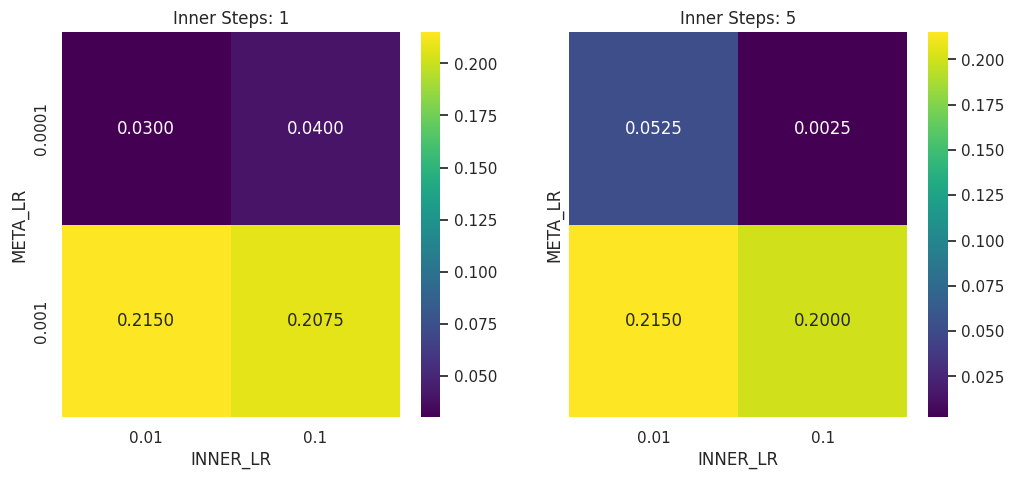


WINNER: MetaLR=0.001, InnerLR=0.01, Steps=5


In [38]:
#################################################################
#  PHASE 5.2: HIGH-PERFORMANCE TUNING (A100 OPTIMIZED)
#################################################################
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

print("\n--- PHASE 5.2: High-Performance Tuning ---")

# --- 1. OPTIMIZED DATA GENERATOR ---
# Wir erweitern den Generator, um 'Chunks' von Tasks zu liefern
class A100TaskGenerator:
    def __init__(self, dataset, ways, shots, query_shots):
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.query_shots = query_shots

        # Caching indices for speed
        self.indices_by_label = {}
        for idx, sample in enumerate(dataset.samples):
            lbl = sample['label']
            if lbl not in self.indices_by_label: self.indices_by_label[lbl] = []
            self.indices_by_label[lbl].append(idx)
        self.classes = list(self.indices_by_label.keys())

    def sample_batch(self, batch_size=32):
        """Generates a whole BATCH of tasks at once to minimize CPU overhead."""
        all_data = []
        all_labels = []

        for _ in range(batch_size):
            selected_classes = random.sample(self.classes, self.ways)
            task_imgs, task_lbls = [], []

            for local_label, global_label in enumerate(selected_classes):
                indices = self.indices_by_label[global_label]
                needed = self.shots + self.query_shots
                # Fast sampling
                selected = random.sample(indices, needed) if len(indices) >= needed else random.choices(indices, k=needed)

                for idx in selected:
                    img, _ = self.dataset[idx]
                    task_imgs.append(img)
                    task_lbls.append(local_label)

            # Stack images for this task: [N_Samples, C, H, W]
            all_data.append(torch.stack(task_imgs))
            all_labels.append(torch.tensor(task_lbls))

        # Return stacked meta-batch: [MetaBatch, N_Samples, C, H, W]
        return torch.stack(all_data), torch.stack(all_labels)

# Wrapper to create the optimized generator
def get_fast_taskset(split, ways=5, shots=5, query_shots=15):
    # Re-use existing MetaINatDataset logic
    train_transforms = transforms.Compose([
        transforms.Resize((84, 84)), # MAML standard size (faster)
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])
    ds = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=train_transforms)
    return A100TaskGenerator(ds, ways, shots, query_shots)


# --- 2. OPTIMIZED STEP FUNCTION ---
def tuning_step_optimized(meta_model, task_generator, meta_optimizer, criterion, device, current_cfg, meta_batch_size):
    meta_loss_total = 0.0
    meta_optimizer.zero_grad()

    # 1. FETCH ALL DATA AT ONCE (CPU -> GPU Transfer happens ONCE)
    tasks_data, tasks_labels = task_generator.sample_batch(batch_size=meta_batch_size)
    tasks_data, tasks_labels = tasks_data.to(device), tasks_labels.to(device)

    # Pre-calculate indices
    ways, shots, queries = 5, 5, 15
    support_indices = []
    query_indices = []
    for w in range(ways):
        base = w * (shots + queries)
        support_indices.extend(range(base, base + shots))
        query_indices.extend(range(base + shots, base + shots + queries))

    # 2. LOOP ON GPU (No more CPU waiting)
    for i in range(meta_batch_size):
        # Slicing on GPU is fast
        supp_X = tasks_data[i][support_indices]
        supp_y = tasks_labels[i][support_indices]
        query_X = tasks_data[i][query_indices]
        query_y = tasks_labels[i][query_indices]

        # --- Standard MAML Inner Loop ---
        fast_model = copy.deepcopy(meta_model)
        fast_model.train()
        inner_opt = optim.SGD(fast_model.parameters(), lr=current_cfg['INNER_LR'])

        for _ in range(current_cfg['INNER_STEPS']):
            preds = fast_model(supp_X)
            loss = criterion(preds, supp_y)
            inner_opt.zero_grad()
            loss.backward()
            inner_opt.step()

        q_preds = fast_model(query_X)
        q_loss = criterion(q_preds, query_y)
        meta_loss_total += q_loss.item()
        q_loss.backward()

        # Accumulate Gradients
        for mp, fp in zip(meta_model.parameters(), fast_model.parameters()):
            if fp.grad is not None:
                grad = fp.grad.detach() / meta_batch_size
                if mp.grad is None: mp.grad = grad
                else: mp.grad += grad

        del fast_model, inner_opt # Free VRAM immediately

    meta_optimizer.step()
    return meta_loss_total / meta_batch_size


# --- 3. TUNING CONFIGURATION ---
GRID_SEARCH = {
    'META_LR': [1e-3, 1e-4],
    'INNER_LR': [0.1, 0.01],
    'INNER_STEPS': [1, 5]
}

TUNING_CONFIG = {
    'ARCH': 'resnet34',
    'SUBSET': 0.25,
    'ITERS': 100,       # Weniger Iterationen, da Batch Size größer!
    'META_BATCH': 32,   # <--- HIER IST DER TURBO! (Standard war 4)
    'VAL_INT': 25,
    'DRY_RUN': False
}

if TUNING_CONFIG['DRY_RUN']:
    TUNING_CONFIG['ITERS'] = 2
    TUNING_CONFIG['VAL_INT'] = 1
    TUNING_CONFIG['META_BATCH'] = 2


# --- 4. RUN ENGINE ---
def run_tuning(combo_params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    meta_model = load_base_model_for_maml(TUNING_CONFIG['SUBSET'], TUNING_CONFIG['ARCH'])
    meta_model = meta_model.to(device)
    meta_optimizer = optim.Adam(meta_model.parameters(), lr=combo_params['META_LR'])
    criterion = nn.CrossEntropyLoss()

    # Use optimized generator
    train_gen = get_fast_taskset(split='c_base')
    val_gen = get_fast_taskset(split='c_val') # Reuse for simplicity

    best_acc = 0.0

    pbar = tqdm(range(TUNING_CONFIG['ITERS']), desc="Run", leave=False)
    for i in pbar:
        loss = tuning_step_optimized(meta_model, train_gen, meta_optimizer, criterion, device, combo_params, TUNING_CONFIG['META_BATCH'])
        pbar.set_postfix(loss=f"{loss:.3f}")

        if (i+1) % TUNING_CONFIG['VAL_INT'] == 0:
            # Quick Validation (Zero-Shot Proxy for speed)
            meta_model.eval()
            correct, total = 0, 0
            # Validate on 1 batch of tasks
            v_data, v_lbl = val_gen.sample_batch(4)
            v_data, v_lbl = v_data.to(device), v_lbl.to(device)
            with torch.no_grad():
                # Flatten batch for simple forward pass check
                B, N, C, H, W = v_data.shape
                logits = meta_model(v_data.view(-1, C, H, W))
                targets = v_lbl.view(-1)
                _, preds = torch.max(logits, 1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)
            acc = correct / total
            if acc > best_acc: best_acc = acc
            meta_model.train()

    return best_acc

# --- 5. EXECUTION ---
print(f"Starting A100 Optimized Tuning (Batch Size {TUNING_CONFIG['META_BATCH']})...")
results = []
keys = list(GRID_SEARCH.keys())
combos = list(itertools.product(*GRID_SEARCH.values()))

combo_pbar = tqdm(combos, desc="Total Progress")
for c in combo_pbar:
    params = dict(zip(keys, c))
    try:
        score = run_tuning(params)
        res = params.copy()
        res['Acc'] = score
        results.append(res)
        combo_pbar.write(f" -> {params} | Acc: {score:.4f}")
    except Exception as e:
        print(f"Error: {e}")

# --- 6. RESULTS ---
if results:
    df = pd.DataFrame(results).sort_values(by='Acc', ascending=False)
    print("\n", df)

    # Heatmap logic
    unique_steps = df['INNER_STEPS'].unique()
    fig, axes = plt.subplots(1, len(unique_steps), figsize=(12, 5), sharey=True)
    if len(unique_steps) == 1: axes = [axes]
    for i, steps in enumerate(sorted(unique_steps)):
        ax = axes[i]
        subset = df[df['INNER_STEPS'] == steps]
        pivot = subset.pivot(index='META_LR', columns='INNER_LR', values='Acc')
        sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis", ax=ax)
        ax.set_title(f"Inner Steps: {steps}")
    plt.show()

    win = df.iloc[0]
    print(f"\nWINNER: MetaLR={win['META_LR']}, InnerLR={win['INNER_LR']}, Steps={int(win['INNER_STEPS'])}")

In [24]:
#################################################################
#  PHASE 6: SETUP & ENGINE (SMART DRY RUN) - BLOCK 1
#################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import pandas as pd
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
from torchvision import models, transforms
from PIL import Image
import json
from google.colab import drive

# Install peft
try: import peft
except ImportError:
    !pip install -q peft
    import peft
from peft import LoraConfig, get_peft_model

print("\n--- PHASE 6: Initialization ---")

# --- 0. DRIVE & PATHS ---
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')
PARTITION_FILE = os.path.join(PROJECT_DIR, 'project_meta', 'inat_class_split.json')

# --- 1. CONFIGURATION ---
TUNING_CONFIG = {
    'ARCH': 'resnet34',
    'SUBSETS': [0.25, 0.50, 1.0],
    'DRY_RUN': False,               # <--- START HERE (Then switch to False)

    # Real Run Settings
    'NUM_TASKS': 50,
    'IMG_SIZE': 128,
    'WAYS': 5, 'SHOTS': 5, 'QUERY_SHOTS': 15,
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

if TUNING_CONFIG['DRY_RUN']:
    TUNING_CONFIG['NUM_TASKS'] = 2
    print("   [MODE] DRY RUN ACTIVE (Smart Mode: 10 Epochs for LoRA Check)")
else:
    print("   [MODE] REAL EXECUTION")

# Search Spaces
FT_GRID = {
    'LR': [1e-3, 1e-4],
    'EPOCHS': [50, 100]
}

LORA_GRID = {
    'LR': [1e-2, 1e-3],
    'EPOCHS': [50, 100],
    'RANK': [4, 8]
}

LORA_TARGETS = ["conv1", "conv2", "fc"]


# --- 2. DATA GENERATOR ---
if 'GLOBAL_VAL_DS' not in globals():
    print("\n   [Info] RAM Cache leer. Lade C_val von Festplatte...")

    class SimpleInat(torch.utils.data.Dataset):
        def __init__(self, root, part_file, transform):
            self.root = root
            self.transform = transform
            with open(part_file, 'r') as f: d = json.load(f)
            self.ids = d['sets']['c_val']
            self.map = d['id_to_path']
            self.samples = []
            for oid in self.ids:
                rel_p = self.map[str(oid)]
                p = os.path.join(root, rel_p)
                if os.path.exists(p):
                    for i in os.listdir(p):
                        if i.lower().endswith(('.jpg', '.jpeg', '.png')):
                            self.samples.append((os.path.join(p, i), oid))
        def __len__(self): return len(self.samples)
        def __getitem__(self, idx):
            p, l = self.samples[idx]
            img = Image.open(p).convert('RGB')
            if self.transform: img = self.transform(img)
            return img, l

    LOCAL_DATA_ROOT = '/content/data/inaturalist_unpacked'
    POSS_ROOTS = [
        os.path.join(LOCAL_DATA_ROOT, '2021_train_mini'),
        os.path.join(LOCAL_DATA_ROOT, 'train_mini'),
        LOCAL_DATA_ROOT
    ]
    REAL_ROOT = next((p for p in POSS_ROOTS if os.path.exists(p)), None)

    if REAL_ROOT is None:
        raise FileNotFoundError(f"Daten nicht gefunden in {LOCAL_DATA_ROOT}. Setup ausgeführt?")

    tf = transforms.Compose([
        transforms.Resize((TUNING_CONFIG['IMG_SIZE'], TUNING_CONFIG['IMG_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    print("   [RAM] Preloading Images into Memory (please wait)...")
    samples_cache = []
    temp_ds = SimpleInat(REAL_ROOT, PARTITION_FILE, None)

    for i in tqdm(range(len(temp_ds)), desc="Caching C_val"):
        p, l = temp_ds.samples[i]
        img = Image.open(p).convert('RGB')
        img = img.resize((TUNING_CONFIG['IMG_SIZE'], TUNING_CONFIG['IMG_SIZE']))
        samples_cache.append((img, l))

    class CachedSimpleInat(torch.utils.data.Dataset):
        def __init__(self, cache, transform):
            self.cache = cache
            self.transform = transform
        def __len__(self): return len(self.cache)
        def __getitem__(self, idx):
            img, l = self.cache[idx]
            if self.transform: img = self.transform(img)
            return img, l

    GLOBAL_VAL_DS = CachedSimpleInat(samples_cache, tf)
    print(f"   [Info] Erfolgreich geladen: {len(GLOBAL_VAL_DS)} Bilder.")

class ValidationTaskGenerator:
    def __init__(self, dataset, ways, shots, queries):
        self.dataset = dataset
        self.ways, self.shots, self.queries = ways, shots, queries
        self.indices = {}
        print("   [Gen] Erstelle Klassen-Index...")
        # Fast Indexing
        for i in range(len(dataset)):
            if hasattr(dataset, 'samples') and isinstance(dataset.samples[0], dict):
                 l = dataset.samples[i]['label'] # Phase 5 compat
            elif hasattr(dataset, 'cache'):
                 l = dataset.cache[i][1] # Phase 6 compat
            else:
                 _, l = dataset[i]

            if l not in self.indices: self.indices[l] = []
            self.indices[l].append(i)
        self.classes = list(self.indices.keys())

    def get_batch(self, num_tasks):
        all_data, all_labels = [], []
        import random
        for _ in range(num_tasks):
            cls = random.sample(self.classes, self.ways)
            imgs, lbls = [], []
            for local_l, global_l in enumerate(cls):
                idxs = self.indices[global_l]
                needed = self.shots + self.queries
                selected = random.sample(idxs, needed) if len(idxs) >= needed else random.choices(idxs, k=needed)
                for idx in selected:
                    img = self.dataset[idx][0]
                    if img.shape[-1] != TUNING_CONFIG['IMG_SIZE']:
                        import torchvision.transforms.functional as F
                        img = F.resize(img, [TUNING_CONFIG['IMG_SIZE'], TUNING_CONFIG['IMG_SIZE']])
                    imgs.append(img)
                    lbls.append(local_l)
            all_data.append(torch.stack(imgs))
            all_labels.append(torch.tensor(lbls))
        return torch.stack(all_data), torch.stack(all_labels)


# --- 3. MODEL LOADER ---
def load_base_model(fraction):
    base_dir = os.path.join(PROJECT_DIR, 'models', 'base_models')
    subset_name = f"M_base_{int(fraction*100)}"
    candidates = [f"{subset_name}_best.pth", f"{subset_name}_checkpoint.pth", f"{subset_name}_dryrun_best.pth"]
    path = None
    for c in candidates:
        p = os.path.join(base_dir, c)
        if os.path.exists(p): path = p; break

    if not path: raise FileNotFoundError(f"Model {subset_name} not found.")

    full_classes = 6000
    num_classes = int(full_classes * fraction)
    model = models.resnet34(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location='cpu'))
    return model

# --- 4. ADAPTATION LOOP (SMART EPOCHS) ---
def adapt_and_evaluate(model_base, support_X, support_y, query_X, query_y, config, mode):
    # 1. Replace Head
    in_features = model_base.fc.in_features
    if model_base.fc.out_features != TUNING_CONFIG['WAYS']:
        model_base.fc = nn.Linear(in_features, TUNING_CONFIG['WAYS']).to(TUNING_CONFIG['DEVICE'])

    # 2. Optimizer
    params = [p for p in model_base.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=config['LR'], weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    # 3. Training (BN Freeze)
    model_base.train()
    for module in model_base.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()

    # --- SMART EPOCH LOGIC ---
    if TUNING_CONFIG['DRY_RUN']:
        # Full FT ist schwer, 1 Epoch reicht für Code Check
        # LoRA braucht Zeit -> wir geben ihm 10 Epochs im Dry Run
        epochs = 10 if mode == 'LORA' else 1
    else:
        epochs = config['EPOCHS']
    # -------------------------

    for _ in range(epochs):
        preds = model_base(support_X)
        loss = criterion(preds, support_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 4. Eval
    model_base.eval()
    with torch.no_grad():
        q_preds = model_base(query_X)
        _, predicted = torch.max(q_preds, 1)
        correct = (predicted == query_y).sum().item()
        return correct / query_y.size(0)

print("Phase 6 Setup Complete (Smart Dry Run Integrated).")


--- PHASE 6: Initialization ---
   [MODE] REAL EXECUTION
Phase 6 Setup Complete (Smart Dry Run Integrated).


Generating 50 Validation Tasks...
   [Gen] Erstelle Klassen-Index...

TUNING MODEL: M_base_25
>>> Method: FULL FINE-TUNING


Full FT:   0%|          | 0/4 [00:00<?, ?it/s]

>>> Method: LoRA


LoRA:   0%|          | 0/8 [00:00<?, ?it/s]


TUNING MODEL: M_base_50
>>> Method: FULL FINE-TUNING


Full FT:   0%|          | 0/4 [00:00<?, ?it/s]

>>> Method: LoRA


LoRA:   0%|          | 0/8 [00:00<?, ?it/s]


TUNING MODEL: M_base_100
>>> Method: FULL FINE-TUNING


Full FT:   0%|          | 0/4 [00:00<?, ?it/s]

>>> Method: LoRA


LoRA:   0%|          | 0/8 [00:00<?, ?it/s]


RESULTS ANALYSIS

[Full FT Accuracy]


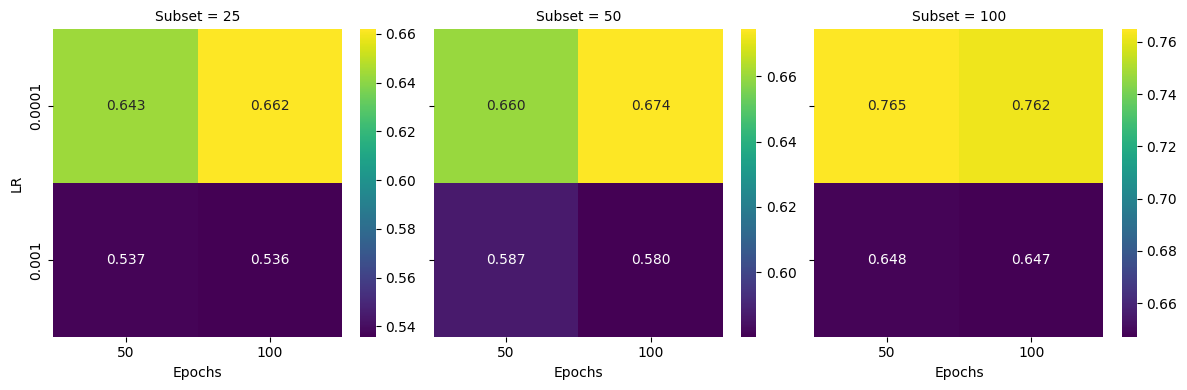


[LoRA Accuracy]


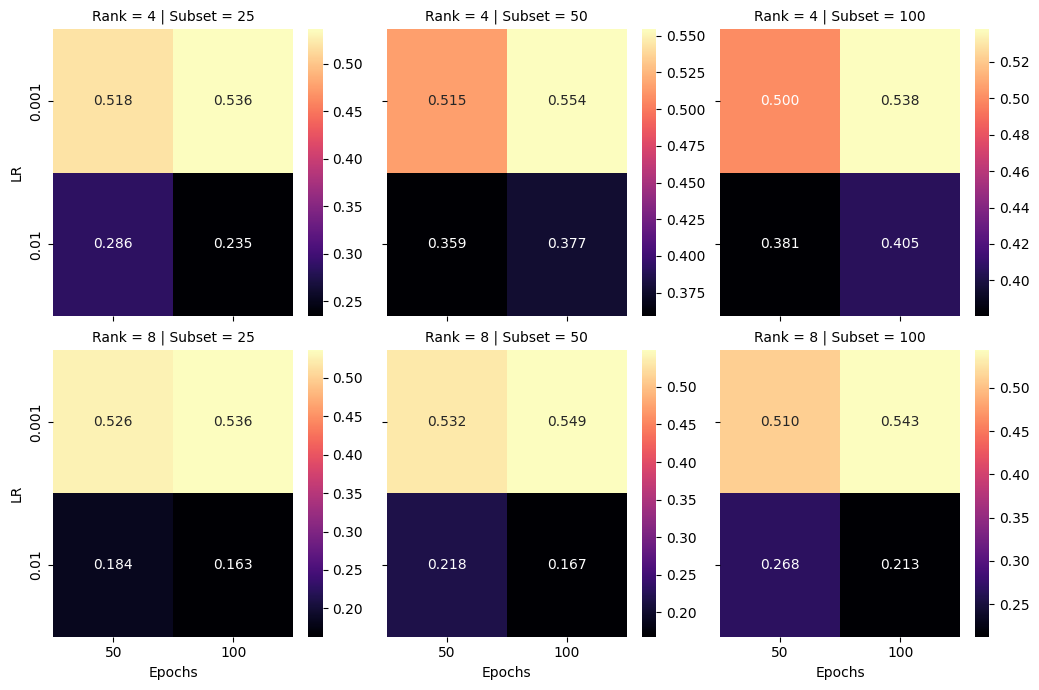


>>> FINAL HYPERPARAMETERS <<<

Model M_base_25:
  FULL FT: LR=0.0001, Ep=100 => Acc: 0.6619
  LoRA:    LR=0.001, Ep=100, Rank=4 => Acc: 0.5360

Model M_base_50:
  FULL FT: LR=0.0001, Ep=100 => Acc: 0.6744
  LoRA:    LR=0.001, Ep=100, Rank=4 => Acc: 0.5544

Model M_base_100:
  FULL FT: LR=0.0001, Ep=50 => Acc: 0.7648
  LoRA:    LR=0.001, Ep=100, Rank=8 => Acc: 0.5435


In [25]:
#################################################################
#  PHASE 6: EXECUTION (BLOCK 2)
#################################################################

# --- PREPARE TASKS ---
print(f"Generating {TUNING_CONFIG['NUM_TASKS']} Validation Tasks...")
val_gen = ValidationTaskGenerator(GLOBAL_VAL_DS, TUNING_CONFIG['WAYS'], TUNING_CONFIG['SHOTS'], TUNING_CONFIG['QUERY_SHOTS'])
tasks_data, tasks_labels = val_gen.get_batch(TUNING_CONFIG['NUM_TASKS'])
tasks_data, tasks_labels = tasks_data.to(TUNING_CONFIG['DEVICE']), tasks_labels.to(TUNING_CONFIG['DEVICE'])

ways, shots, queries = TUNING_CONFIG['WAYS'], TUNING_CONFIG['SHOTS'], TUNING_CONFIG['QUERY_SHOTS']
supp_idx, query_idx = [], []
for w in range(ways):
    b = w * (shots + queries)
    supp_idx.extend(range(b, b + shots))
    query_idx.extend(range(b + shots, b + shots + queries))

final_results = []

# --- MAIN LOOP ---
for subset in TUNING_CONFIG['SUBSETS']:
    print(f"\n{'='*60}")
    print(f"TUNING MODEL: M_base_{int(subset*100)}")
    print(f"{'='*60}")

    try:
        base_model_cpu = load_base_model(subset)
    except FileNotFoundError as e:
        print(f"Skipping {subset}: {e}")
        continue

    # --- 1. FULL FT ---
    print(">>> Method: FULL FINE-TUNING")
    combos = list(itertools.product(FT_GRID['LR'], FT_GRID['EPOCHS']))
    for lr, ep in tqdm(combos, desc="Full FT"):
        cfg = {'LR': lr, 'EPOCHS': ep}
        accs = []
        for t in range(TUNING_CONFIG['NUM_TASKS']):
            model = copy.deepcopy(base_model_cpu).to(TUNING_CONFIG['DEVICE'])
            for p in model.parameters(): p.requires_grad = True

            sX, sY = tasks_data[t][supp_idx], tasks_labels[t][supp_idx]
            qX, qY = tasks_data[t][query_idx], tasks_labels[t][query_idx]

            # WICHTIG: Mode übergeben!
            accs.append(adapt_and_evaluate(model, sX, sY, qX, qY, cfg, mode='FULL'))
            del model

        final_results.append({'Subset': int(subset*100), 'Method': 'Full_FT', 'LR': lr, 'Epochs': ep, 'Rank': 0, 'Acc': np.mean(accs)})

    # --- 2. LORA ---
    print(">>> Method: LoRA")
    combos_lora = list(itertools.product(LORA_GRID['LR'], LORA_GRID['EPOCHS'], LORA_GRID['RANK']))
    for lr, ep, r in tqdm(combos_lora, desc="LoRA"):
        cfg = {'LR': lr, 'EPOCHS': ep}
        accs = []
        for t in range(TUNING_CONFIG['NUM_TASKS']):
            model_temp = copy.deepcopy(base_model_cpu)
            peft_config = LoraConfig(r=r, lora_alpha=r*2, target_modules=LORA_TARGETS, lora_dropout=0.1, bias="none")
            model = get_peft_model(model_temp, peft_config).to(TUNING_CONFIG['DEVICE'])

            sX, sY = tasks_data[t][supp_idx], tasks_labels[t][supp_idx]
            qX, qY = tasks_data[t][query_idx], tasks_labels[t][query_idx]

            # WICHTIG: Mode übergeben!
            accs.append(adapt_and_evaluate(model, sX, sY, qX, qY, cfg, mode='LORA'))
            del model, model_temp

        final_results.append({'Subset': int(subset*100), 'Method': 'LoRA', 'LR': lr, 'Epochs': ep, 'Rank': r, 'Acc': np.mean(accs)})

    del base_model_cpu
    torch.cuda.empty_cache()

# --- VISUALIZATION ---
print("\n" + "="*60)
print("RESULTS ANALYSIS")
print("="*60)
df = pd.DataFrame(final_results)

if not df.empty:
    print("\n[Full FT Accuracy]")
    ft_data = df[df['Method'] == 'Full_FT']
    if not ft_data.empty:
        g = sns.FacetGrid(ft_data, col="Subset", height=4)
        g.map_dataframe(lambda data, **k: sns.heatmap(data.pivot(index='LR', columns='Epochs', values='Acc'), annot=True, fmt=".3f", cmap="viridis"))
        plt.show()

    print("\n[LoRA Accuracy]")
    lora_data = df[df['Method'] == 'LoRA']
    if not lora_data.empty:
        g = sns.FacetGrid(lora_data, row="Rank", col="Subset", height=3.5)
        g.map_dataframe(lambda data, **k: sns.heatmap(data.pivot(index='LR', columns='Epochs', values='Acc'), annot=True, fmt=".3f", cmap="magma"))
        plt.show()

    print("\n>>> FINAL HYPERPARAMETERS <<<")
    for sub in df['Subset'].unique():
        print(f"\nModel M_base_{sub}:")
        sub_df = df[df['Subset'] == sub]

        best_ft = sub_df[sub_df['Method'] == 'Full_FT'].sort_values('Acc', ascending=False).iloc[0]
        print(f"  FULL FT: LR={best_ft['LR']}, Ep={best_ft['Epochs']} => Acc: {best_ft['Acc']:.4f}")

        best_lora = sub_df[sub_df['Method'] == 'LoRA'].sort_values('Acc', ascending=False).iloc[0]
        print(f"  LoRA:    LR={best_lora['LR']}, Ep={best_lora['Epochs']}, Rank={best_lora['Rank']} => Acc: {best_lora['Acc']:.4f}")
else:
    print("No results.")

In [32]:
#################################################################
#  UNIVERSAL RAM & VRAM CLEANER (ALL PHASES)
#################################################################
import gc
import torch
import sys

print("--- UNIVERSAL CLEANUP STARTED ---")

# 1. Liste der speicherintensiven Variablen aus ALLEN Phasen
# (Datasets, Loader, Modelle, Generatoren)
heavy_vars = [
    # Phase 2/4/5 Datasets & Loaders
    'GLOBAL_TRAIN_DS', 'GLOBAL_VAL_DS', 'GLOBAL_NOVEL_DS',
    'train_loader', 'val_loader', 'train_dl', 'val_dl',
    'train_gen', 'val_gen', 'task_gen',
    'full_ds', 'train_ds', 'val_ds',

    # Phase 4/5/6 Models
    'model', 'meta_model', 'base_model', 'peft_model',
    'base_model_cpu', 'maml_model_cpu', 'model_temp',
    'optimizer', 'meta_optimizer', 'scaler', 'scheduler',

    # Phase 5/6 Data Batches
    'tasks_data', 'tasks_labels',
    'batch_data', 'batch_labels',
    'sX', 'sY', 'qX', 'qY'
]

deleted_count = 0
freed_memory = 0

# 2. Delete Variables from Global Namespace
for var_name in heavy_vars:
    if var_name in globals():
        # Optional: Versuchen Größe zu schätzen (ungenau in Python, aber nett)
        obj = globals()[var_name]
        del globals()[var_name]
        deleted_count += 1
        # print(f" -> Deleted: {var_name}")

print(f" -> Removed {deleted_count} heavy objects from namespace.")

# 3. Force Garbage Collection (Python RAM)
gc.collect()

# 4. Empty GPU Cache (VRAM)
if torch.cuda.is_available():
    pre_mem = torch.cuda.memory_allocated()
    torch.cuda.empty_cache()
    post_mem = torch.cuda.memory_allocated()
    print(f" -> VRAM cleared: {(pre_mem - post_mem) / 1e6:.2f} MB released.")
    print(f" -> Current VRAM usage: {post_mem / 1e6:.2f} MB")

print("--- CLEANUP COMPLETE. READY FOR PHASE 7 ---")

--- UNIVERSAL CLEANUP STARTED ---
 -> Removed 13 heavy objects from namespace.
 -> VRAM cleared: 0.00 MB released.
 -> Current VRAM usage: 119.10 MB
--- CLEANUP COMPLETE. READY FOR PHASE 7 ---



--- PHASE 7: Final Evaluation (Scientific Rigor) ---
>>> LOADING C_NOVEL (Test Set) TO RAM <<<


Caching C_novel:   0%|          | 0/100000 [00:00<?, ?it/s]


>>> STARTING EXPERIMENT MATRIX <<<

Loading Models for M_base_25...
   Testing K=1 Shots... Done.
   Testing K=5 Shots... Done.
   Testing K=10 Shots... Done.
   Testing K=20 Shots... Done.

Loading Models for M_base_50...
   Testing K=1 Shots... Done.
   Testing K=5 Shots... Done.
   Testing K=10 Shots... Done.
   Testing K=20 Shots... Done.

Loading Models for M_base_100...
   Testing K=1 Shots... Done.
   Testing K=5 Shots... Done.
   Testing K=10 Shots... Done.
   Testing K=20 Shots... Done.

Generating Final Report...
    Subset  Shots Method       Acc   Acc_Std  Time_sec      VRAM_MB  \
0       25      1     FT  0.456267  0.122152  1.578875   538.276367   
1       25      1   LORA  0.425333  0.109861  3.023358   303.575195   
2       25      1   MAML  0.277867  0.076472  0.085857   358.465820   
3       25      5     FT  0.667467  0.093615  1.575303   733.024609   
4       25      5   LORA  0.659467  0.092384  3.081020   604.081504   
5       25      5   MAML  0.288000  0.090863

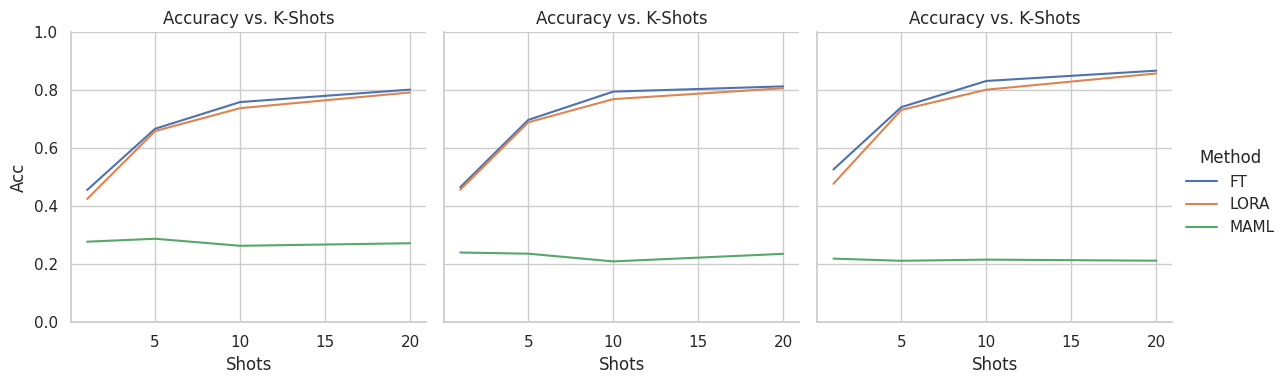

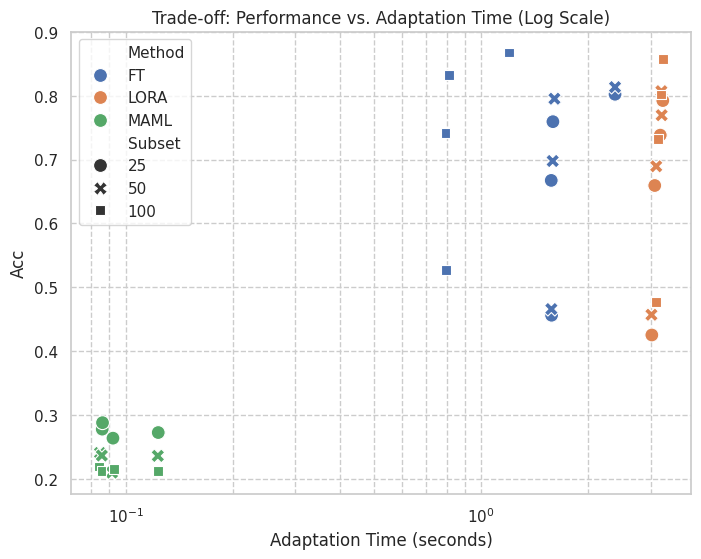

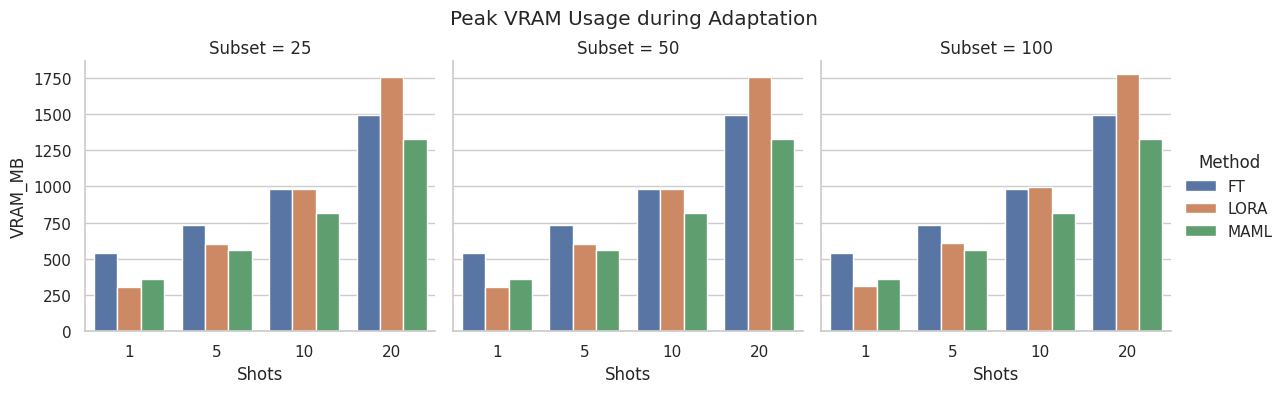

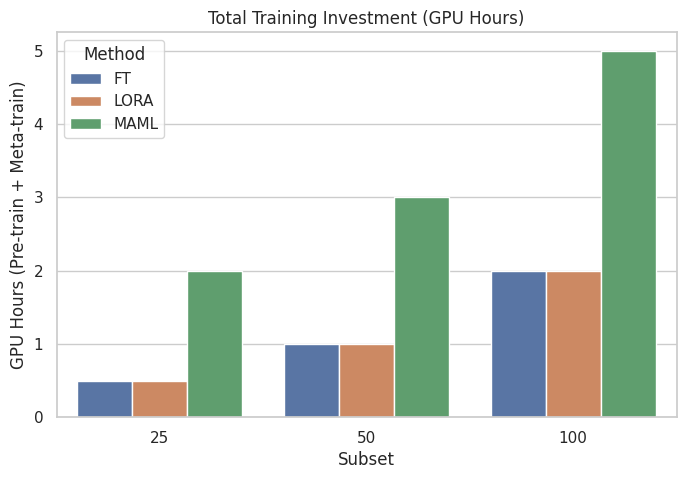


PHASE 7 COMPLETE. SAVE THE PLOTS!


In [33]:
#################################################################
#  PHASE 7: FINAL EVALUATION (SCIENTIFIC RIGOR EDITION)
#################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import pandas as pd
import numpy as np
import os
import json
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import models, transforms
from PIL import Image

# Install peft
try: import peft
except ImportError:
    !pip install -q peft
    import peft
from peft import LoraConfig, get_peft_model

print("\n--- PHASE 7: Final Evaluation (Scientific Rigor) ---")

# --- 0. SETUP & PATHS ---
if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')
PARTITION_FILE = os.path.join(PROJECT_DIR, 'project_meta', 'inat_class_split.json')
BASE_MODELS_DIR = os.path.join(PROJECT_DIR, 'models', 'base_models')
MAML_MODELS_DIR = os.path.join(PROJECT_DIR, 'models', 'maml_models')

# --- 1. EXPERIMENT CONFIGURATION ---
# Die Matrix aus dem Projektplan (Phase 3.3)
EVAL_CONFIG = {
    'K_SHOTS_LIST': [1, 5, 10, 20],  # Die 4 Stufen der Datenknappheit
    'SUBSETS': [0.25, 0.50, 1.0],    # Die 3 Basis-Modell-Größen
    'NUM_TEST_TASKS': 50,            # Wie oft wiederholen wir pro Punkt? (Robustheit)
    'IMG_SIZE': 128,                 # Konsistent zu Phase 5/6
    'WAYS': 5,                       # 5-Way Classification
    'QUERY_SHOTS': 15,
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# WINNER CONFIGURATIONS (Hier manuell die Werte aus Phase 6 eintragen!)
# Beispielwerte (Ersetze diese mit deinen Ergebnissen aus dem Tuning!)
WINNERS = {
    'M_base_25':  {'FT': {'LR': 1e-4, 'EP': 100}, 'LORA': {'LR': 1e-3, 'EP': 100, 'R': 4}, 'MAML': {'LR': 0.01, 'STEPS': 5}},
    'M_base_50':  {'FT': {'LR': 1e-4, 'EP': 100}, 'LORA': {'LR': 1e-3, 'EP': 100, 'R': 4}, 'MAML': {'LR': 0.01, 'STEPS': 5}},
    'M_base_100': {'FT': {'LR': 1e-4, 'EP': 50},  'LORA': {'LR': 1e-3, 'EP': 100, 'R': 8}, 'MAML': {'LR': 0.01, 'STEPS': 5}}
}

# ESTIMATED TRAINING TIME (Investitionskosten in Stunden)
# Schätze diese Werte basierend auf deinen Logs aus Phase 4 und 5
INVESTMENT_COST = {
    'M_base_25':  {'FT': 0.5, 'LORA': 0.5, 'MAML': 0.5 + 1.5}, # Pretrain + Meta
    'M_base_50':  {'FT': 1.0, 'LORA': 1.0, 'MAML': 1.0 + 2.0},
    'M_base_100': {'FT': 2.0, 'LORA': 2.0, 'MAML': 2.0 + 3.0}
}


# --- 2. DATA LOADING (C_NOVEL -> RAM) ---
class SimpleInat(torch.utils.data.Dataset):
    def __init__(self, root, part_file, split, transform):
        with open(part_file, 'r') as f: d = json.load(f)
        self.ids = d['sets'][split]
        self.map = d['id_to_path']
        self.samples = []
        for oid in self.ids:
            p = os.path.join(root, self.map[str(oid)])
            if os.path.exists(p):
                for i in os.listdir(p):
                    if i.lower().endswith(('jpg', 'png')): self.samples.append((os.path.join(p, i), oid))
        self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

def load_c_novel_ram():
    if 'GLOBAL_NOVEL_DS' in globals(): return globals()['GLOBAL_NOVEL_DS']

    print(">>> LOADING C_NOVEL (Test Set) TO RAM <<<")
    LOCAL_ROOT = '/content/data/inaturalist_unpacked'
    POSS_ROOTS = [os.path.join(LOCAL_ROOT, 'train_mini'), LOCAL_ROOT]
    REAL_ROOT = next((p for p in POSS_ROOTS if os.path.exists(p)), None)

    tf = transforms.Compose([
        transforms.Resize((EVAL_CONFIG['IMG_SIZE'], EVAL_CONFIG['IMG_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    raw_ds = SimpleInat(REAL_ROOT, PARTITION_FILE, 'c_novel', None)
    cache = []
    for p, l in tqdm(raw_ds.samples, desc="Caching C_novel"):
        img = Image.open(p).convert('RGB').resize((EVAL_CONFIG['IMG_SIZE'], EVAL_CONFIG['IMG_SIZE']))
        cache.append((img, l))

    class CachedDS(torch.utils.data.Dataset):
        def __init__(self, cache, transform): self.c=cache; self.t=transform
        def __len__(self): return len(self.c)
        def __getitem__(self, i):
            im, l = self.c[i]
            return self.t(im), l
    return CachedDS(cache, tf)

GLOBAL_NOVEL_DS = load_c_novel_ram()

class DynamicTaskGenerator:
    """Generates tasks with VARIABLE K-Shots on the fly."""
    def __init__(self, dataset):
        self.ds = dataset
        self.indices = {}
        for i in range(len(dataset)):
            l = dataset.c[i][1]
            if l not in self.indices: self.indices[l] = []
            self.indices[l].append(i)
        self.classes = list(self.indices.keys())

    def get_task(self, ways, shots, queries):
        cls = random.sample(self.classes, ways)
        s_imgs, s_lbls, q_imgs, q_lbls = [], [], [], []
        for local_l, global_l in enumerate(cls):
            idxs = self.indices[global_l]
            needed = shots + queries
            # Sampling with replacement if class too small (rare edge case in iNat mini)
            selected = random.sample(idxs, needed) if len(idxs) >= needed else random.choices(idxs, k=needed)

            for k in range(shots):
                s_imgs.append(self.ds[selected[k]][0])
                s_lbls.append(local_l)
            for k in range(shots, needed):
                q_imgs.append(self.ds[selected[k]][0])
                q_lbls.append(local_l)
        return torch.stack(s_imgs), torch.tensor(s_lbls), torch.stack(q_imgs), torch.tensor(q_lbls)

# --- 3. METRIC MEASUREMENT ENGINE ---
def measure_adaptation(model, sX, sY, qX, qY, method, params):
    """
    The Core Engine: Measures Accuracy, Time, and VRAM.
    """
    device = EVAL_CONFIG['DEVICE']
    model = copy.deepcopy(model).to(device)

    # 1. Setup Head
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, EVAL_CONFIG['WAYS']).to(device)

    # 2. Setup Method specific logic
    optimizer = None
    if method == 'LORA':
        config = LoraConfig(r=params['R'], lora_alpha=params['R']*2, target_modules=["conv1", "conv2", "fc"], lora_dropout=0.1, bias="none")
        model = get_peft_model(model, config).to(device)
        opt_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(opt_params, lr=params['LR'], weight_decay=1e-4)
        steps = params['EP'] # Epochs

    elif method == 'FT':
        opt_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(opt_params, lr=params['LR'], weight_decay=1e-4)
        steps = params['EP'] # Epochs

    elif method == 'MAML':
        optimizer = optim.SGD(model.parameters(), lr=params['LR'])
        steps = params['STEPS'] # Gradient Steps

    criterion = nn.CrossEntropyLoss()

    # --- START MEASUREMENT ---
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    start_time = time.perf_counter()

    # --- ADAPTATION LOOP ---
    model.train()
    # BN Freeze for FT/LoRA (Safety)
    if method != 'MAML':
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d): m.eval()

    for _ in range(steps):
        preds = model(sX)
        loss = criterion(preds, sY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- STOP MEASUREMENT ---
    torch.cuda.synchronize() # Wait for GPU
    end_time = time.perf_counter()
    peak_vram = torch.cuda.max_memory_allocated() / (1024**2) # In MB

    # --- EVALUATION ---
    model.eval()
    with torch.no_grad():
        q_preds = model(qX)
        _, p = torch.max(q_preds, 1)
        acc = (p == qY).sum().item() / qY.size(0)

    del model, optimizer
    return acc, (end_time - start_time), peak_vram


# --- 4. MAIN EXPERIMENT MATRIX LOOP ---
task_gen = DynamicTaskGenerator(GLOBAL_NOVEL_DS)
results_table = []

print("\n>>> STARTING EXPERIMENT MATRIX <<<")

for subset in EVAL_CONFIG['SUBSETS']:
    subset_name = f"M_base_{int(subset*100)}"
    print(f"\nLoading Models for {subset_name}...")

    # Load Models to CPU RAM once
    path_base = os.path.join(BASE_MODELS_DIR, f"{subset_name}_best.pth")
    if not os.path.exists(path_base): path_base = os.path.join(BASE_MODELS_DIR, f"{subset_name}_checkpoint.pth")

    path_maml = os.path.join(MAML_MODELS_DIR, f"M_maml_{int(subset*100)}_best.pth")

    # Init Architecture
    full_classes = 6000
    num_classes = int(full_classes * subset)

    # Base Model (for FT/LoRA)
    base_model_cpu = models.resnet34(weights=None)
    base_model_cpu.fc = nn.Linear(base_model_cpu.fc.in_features, num_classes)
    base_model_cpu.load_state_dict(torch.load(path_base, map_location='cpu'))

    # MAML Model
    maml_model_cpu = copy.deepcopy(base_model_cpu)
    if os.path.exists(path_maml):
        maml_model_cpu.load_state_dict(torch.load(path_maml, map_location='cpu'))
    else:
        print(f"WARNING: MAML model for {subset_name} not found. Skipping MAML.")
        maml_model_cpu = None

    # Get Winners
    p_ft = WINNERS[subset_name]['FT']
    p_lora = WINNERS[subset_name]['LORA']
    p_maml = WINNERS[subset_name]['MAML']

    # Iterate Axis 2: K-Shots
    for k in EVAL_CONFIG['K_SHOTS_LIST']:
        print(f"   Testing K={k} Shots...", end="")

        metrics = {'FT': [], 'LORA': [], 'MAML': []}

        # Repeated Evaluation
        for t in range(EVAL_CONFIG['NUM_TEST_TASKS']):
            sX, sY, qX, qY = task_gen.get_task(EVAL_CONFIG['WAYS'], k, EVAL_CONFIG['QUERY_SHOTS'])
            sX, sY, qX, qY = sX.to(EVAL_CONFIG['DEVICE']), sY.to(EVAL_CONFIG['DEVICE']), qX.to(EVAL_CONFIG['DEVICE']), qY.to(EVAL_CONFIG['DEVICE'])

            # Measure FT
            acc, t_sec, vram = measure_adaptation(base_model_cpu, sX, sY, qX, qY, 'FT', p_ft)
            metrics['FT'].append([acc, t_sec, vram])

            # Measure LoRA
            acc, t_sec, vram = measure_adaptation(base_model_cpu, sX, sY, qX, qY, 'LORA', p_lora)
            metrics['LORA'].append([acc, t_sec, vram])

            # Measure MAML
            if maml_model_cpu:
                acc, t_sec, vram = measure_adaptation(maml_model_cpu, sX, sY, qX, qY, 'MAML', p_maml)
                metrics['MAML'].append([acc, t_sec, vram])

        print(" Done.")

        # Aggregate & Store
        for method, data in metrics.items():
            if not data: continue
            arr = np.array(data) # [[acc, time, vram], ...]
            mean = np.mean(arr, axis=0)
            std = np.std(arr, axis=0)

            # Append to Master Table
            results_table.append({
                'Subset': int(subset*100),
                'Shots': k,
                'Method': method,
                'Acc': mean[0],
                'Acc_Std': std[0],
                'Time_sec': mean[1],
                'VRAM_MB': mean[2],
                'Invest_Hours': INVESTMENT_COST[subset_name][method]
            })

# --- 5. FINAL VISUALIZATION (THE 4 PLOTS) ---
print("\nGenerating Final Report...")
df = pd.DataFrame(results_table)
print(df)

sns.set_theme(style="whitegrid")

# PLOT 1: Performance vs. Data (The Core Result)
g = sns.relplot(data=df, x="Shots", y="Acc", hue="Method", col="Subset", kind="line", markers=True, height=4, aspect=1)
g.set(ylim=(0, 1.0), title="Accuracy vs. K-Shots")
plt.show()

# PLOT 2: Efficiency Trade-off (Scatter)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Time_sec", y="Acc", hue="Method", style="Subset", s=100)
plt.xscale('log') # WICHTIG für Zeit
plt.title("Trade-off: Performance vs. Adaptation Time (Log Scale)")
plt.xlabel("Adaptation Time (seconds)")
plt.grid(True, which="both", ls="--")
plt.show()

# PLOT 3: VRAM Efficiency (Bar)
g = sns.catplot(data=df, x="Shots", y="VRAM_MB", hue="Method", col="Subset", kind="bar", height=4, aspect=1)
g.fig.suptitle("Peak VRAM Usage during Adaptation")
plt.subplots_adjust(top=0.85)
plt.show()

# PLOT 4: Total Investment (Training Cost)
# We aggregate unique methods per subset (since cost is constant across K)
df_cost = df[['Subset', 'Method', 'Invest_Hours']].drop_duplicates()
plt.figure(figsize=(8, 5))
sns.barplot(data=df_cost, x="Subset", y="Invest_Hours", hue="Method")
plt.title("Total Training Investment (GPU Hours)")
plt.ylabel("GPU Hours (Pre-train + Meta-train)")
plt.show()

print("\nPHASE 7 COMPLETE. SAVE THE PLOTS!")


--- PHASE 7.5: Advanced Analysis ---

>>> 1. GENERATING LEARNING CURVES (M_base_100) <<<
   Running Full FT...
   Running LoRA...
   Running MAML...


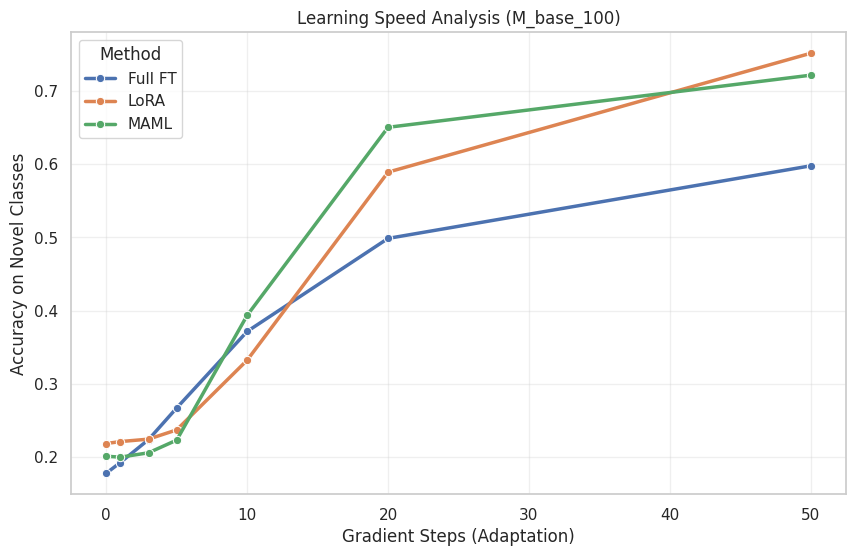


>>> 2. FAIL CASE ANALYSIS <<<
Analyzing Fail Cases for MAML...


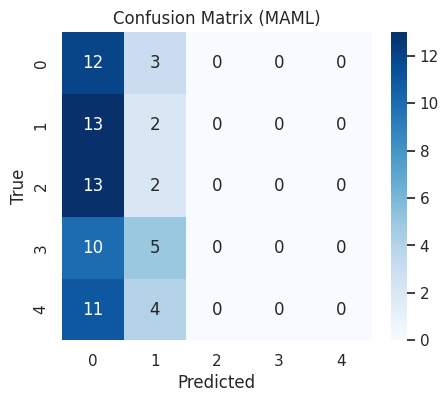

Top 5 High-Confidence Errors:


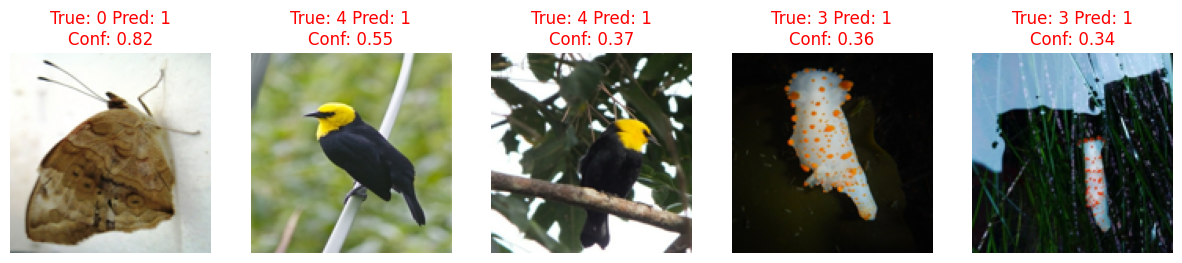

In [35]:
#################################################################
#  PHASE 7.5: DEEP DIVE ANALYSIS (CORRECTED CONFIG)
#################################################################
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from peft import LoraConfig, get_peft_model
from torchvision import models

print("\n--- PHASE 7.5: Advanced Analysis ---")

# --- 0. CONFIGURATION (FIXED) ---
DD_CONFIG = {
    'SUBSET': 1.0,               # <--- KORREKTUR: 1.0 statt 100 (für M_base_100)
    'STEPS_TO_PROBE': [0, 1, 3, 5, 10, 20, 50],
    'NUM_CURVE_TASKS': 20,       # Mittelwert über 20 Tasks
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- 1. SAFETY CHECK & LOADERS ---
# Wir definieren die Loader hier lokal neu, um sicher zu sein, dass sie funktionieren
if 'WINNERS' not in globals() or 'GLOBAL_NOVEL_DS' not in globals():
    raise NameError("Bitte führe zuerst Phase 7 aus (Data & Winners müssen im Speicher sein).")

def load_m_base_safe(fraction):
    base_dir = os.path.join(PROJECT_DIR, 'models', 'base_models')
    subset_name = f"M_base_{int(fraction*100)}"

    # Priority search
    paths = [
        os.path.join(base_dir, f"{subset_name}_best.pth"),
        os.path.join(base_dir, f"{subset_name}_checkpoint.pth"),
        os.path.join(base_dir, f"{subset_name}_dryrun_best.pth")
    ]
    path = next((p for p in paths if os.path.exists(p)), None)

    if not path: raise FileNotFoundError(f"Base Model {subset_name} not found.")

    full_classes = 6000
    num_classes = int(full_classes * fraction)
    model = models.resnet34(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location='cpu'))
    return model

def load_m_maml_safe(fraction):
    maml_dir = os.path.join(PROJECT_DIR, 'models', 'maml_models')
    subset_name = f"M_maml_{int(fraction*100)}"

    paths = [
        os.path.join(maml_dir, f"{subset_name}_best.pth"),
        os.path.join(maml_dir, f"{subset_name}_checkpoint.pth"),
        os.path.join(maml_dir, f"{subset_name}_dryrun_best.pth")
    ]
    path = next((p for p in paths if os.path.exists(p)), None)

    if not path:
        print(f"[Warning] MAML Model {subset_name} not found.")
        return None

    full_classes = 6000
    num_classes = int(full_classes * fraction)
    model = models.resnet34(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location='cpu'))
    return model

# --- HELPER: DENORMALIZE IMAGE ---
def denorm(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    img = tensor * std + mean
    img = img.clamp(0, 1)
    return img.permute(1, 2, 0).cpu().numpy()

# --- 2. LEARNING CURVE ENGINE ---
def measure_learning_curve(model_base, method, params, task_gen):
    curve_scores = {step: [] for step in DD_CONFIG['STEPS_TO_PROBE']}

    # Silent run (no print per task)
    for _ in range(DD_CONFIG['NUM_CURVE_TASKS']):
        sX, sY, qX, qY = task_gen.get_task(5, 5, 15)
        sX, sY, qX, qY = sX.to(DD_CONFIG['DEVICE']), sY.to(DD_CONFIG['DEVICE']), qX.to(DD_CONFIG['DEVICE']), qY.to(DD_CONFIG['DEVICE'])

        model = copy.deepcopy(model_base).to(DD_CONFIG['DEVICE'])
        # Head Init
        model.fc = nn.Linear(model.fc.in_features, 5).to(DD_CONFIG['DEVICE'])

        optimizer = None
        if method == 'LORA':
            cfg = LoraConfig(r=params['R'], lora_alpha=params['R']*2, target_modules=["conv1", "conv2", "fc"], lora_dropout=0.1, bias="none")
            model = get_peft_model(model, cfg)
            opt_params = [p for p in model.parameters() if p.requires_grad]
            optimizer = optim.AdamW(opt_params, lr=params['LR'], weight_decay=1e-4)
        elif method == 'FT':
            opt_params = [p for p in model.parameters() if p.requires_grad]
            optimizer = optim.AdamW(opt_params, lr=params['LR'], weight_decay=1e-4)
        elif method == 'MAML':
            optimizer = optim.SGD(model.parameters(), lr=params['LR'])

        criterion = nn.CrossEntropyLoss()

        # Loop Steps
        model.train()
        if method != 'MAML':
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d): m.eval()

        current_step = 0
        max_step = max(DD_CONFIG['STEPS_TO_PROBE'])

        while current_step <= max_step:
            # Checkpoint measure
            if current_step in DD_CONFIG['STEPS_TO_PROBE']:
                model.eval()
                with torch.no_grad():
                    q_preds = model(qX)
                    _, p = torch.max(q_preds, 1)
                    acc = (p == qY).sum().item() / qY.size(0)
                    curve_scores[current_step].append(acc)
                model.train()

            if current_step == max_step: break

            # Update
            preds = model(sX)
            loss = criterion(preds, sY)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            current_step += 1

    return {k: np.mean(v) for k, v in curve_scores.items()}


# --- 3. EXECUTION: LEARNING CURVES ---
print(f"\n>>> 1. GENERATING LEARNING CURVES (M_base_{int(DD_CONFIG['SUBSET']*100)}) <<<")
# Reuse Generator from Phase 7
task_gen = DynamicTaskGenerator(GLOBAL_NOVEL_DS)
subset_key = f"M_base_{int(DD_CONFIG['SUBSET']*100)}"

# Load Models
base_model = load_m_base_safe(DD_CONFIG['SUBSET'])
maml_model = load_m_maml_safe(DD_CONFIG['SUBSET'])

# Get Params
p_ft = WINNERS[subset_key]['FT']
p_lora = WINNERS[subset_key]['LORA']
p_maml = WINNERS[subset_key]['MAML']

# Run
curve_results = []
print("   Running Full FT...")
ft_curve = measure_learning_curve(base_model, 'FT', p_ft, task_gen)
for step, acc in ft_curve.items(): curve_results.append({'Method': 'Full FT', 'Step': step, 'Acc': acc})

print("   Running LoRA...")
lora_curve = measure_learning_curve(base_model, 'LORA', p_lora, task_gen)
for step, acc in lora_curve.items(): curve_results.append({'Method': 'LoRA', 'Step': step, 'Acc': acc})

if maml_model:
    print("   Running MAML...")
    maml_curve = measure_learning_curve(maml_model, 'MAML', p_maml, task_gen)
    for step, acc in maml_curve.items(): curve_results.append({'Method': 'MAML', 'Step': step, 'Acc': acc})

# Plot
df_curve = pd.DataFrame(curve_results)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_curve, x='Step', y='Acc', hue='Method', marker='o', linewidth=2.5)
plt.title(f"Learning Speed Analysis ({subset_key})")
plt.ylabel("Accuracy on Novel Classes")
plt.xlabel("Gradient Steps (Adaptation)")
plt.grid(True, alpha=0.3)
plt.show()


# --- 4. EXECUTION: FAIL CASES ---
print("\n>>> 2. FAIL CASE ANALYSIS <<<")
# One task
sX, sY, qX, qY = task_gen.get_task(5, 5, 15)
sX, sY, qX, qY = sX.to(DD_CONFIG['DEVICE']), sY.to(DD_CONFIG['DEVICE']), qX.to(DD_CONFIG['DEVICE']), qY.to(DD_CONFIG['DEVICE'])

def analyze_single_task(model_base, method, params):
    model = copy.deepcopy(model_base).to(DD_CONFIG['DEVICE'])
    model.fc = nn.Linear(model.fc.in_features, 5).to(DD_CONFIG['DEVICE'])

    if method == 'LORA':
        cfg = LoraConfig(r=params['R'], lora_alpha=params['R']*2, target_modules=["conv1", "conv2", "fc"], bias="none")
        model = get_peft_model(model, cfg)
        optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=params['LR'])
        steps = params['EP']
    elif method == 'FT':
        optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=params['LR'])
        steps = params['EP']
    elif method == 'MAML':
        optimizer = optim.SGD(model.parameters(), lr=params['LR'])
        steps = params['STEPS']

    criterion = nn.CrossEntropyLoss()
    model.train()
    if method != 'MAML':
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d): m.eval()

    for _ in range(steps):
        preds = model(sX)
        loss = criterion(preds, sY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(qX)
        probs = F.softmax(logits, dim=1)
        conf, preds = torch.max(probs, 1)

    return preds.cpu().numpy(), qY.cpu().numpy(), conf.cpu().numpy()

# Analyze MAML (or FT if MAML missing)
target_method = 'MAML' if maml_model else 'Full FT'
target_model = maml_model if maml_model else base_model
target_params = p_maml if maml_model else p_ft

print(f"Analyzing Fail Cases for {target_method}...")
preds, trues, confs = analyze_single_task(target_model, target_method, target_params)

# Confusion Matrix
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix ({target_method})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Top Failures
failures = []
for i in range(len(preds)):
    if preds[i] != trues[i]:
        failures.append({'idx': i, 'true': trues[i], 'pred': preds[i], 'conf': confs[i]})

failures = sorted(failures, key=lambda x: x['conf'], reverse=True)[:5]

if failures:
    print(f"Top {len(failures)} High-Confidence Errors:")
    fig, axes = plt.subplots(1, len(failures), figsize=(15, 3))
    if len(failures) == 1: axes = [axes]
    for ax, fail in zip(axes, failures):
        img = qX[fail['idx']]
        ax.imshow(denorm(img))
        ax.axis('off')
        ax.set_title(f"True: {fail['true']} Pred: {fail['pred']}\nConf: {fail['conf']:.2f}", color='red')
    plt.show()
else:
    print("No errors found on this task! Perfect score.")